In [184]:
import mglearn #library provided by amueller
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.options.display.float_format = '{:,.4g}'.format
from sklearn.linear_model import * #Import the library of all ML models
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pylab as plot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

In [185]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import *


class Preprocessor:
    """
    A preprocessing class for handling feature transformations in an AutoML pipeline.

    This class provides various methods to preprocess dataset features, including:
    - One-hot encoding categorical variables
    - Mapping ordinal categorical variables to numerical values
    - Performing basic feature engineering (addition, subtraction, multiplication, division)
    - Automatically generating interaction features by multiplying all pairs of features
    - Scales values based on either Z-score, or minMax scaling
    - Transforms values through a power transformation
    - Returning the processed dataset

    Methods support method chaining for seamless transformations.

    Attributes:
    -----------
    scaler : StandardScaler
        Standard scaler for numerical feature normalization (not yet utilized in current implementation).
    encoder : OneHotEncoder
        Encoder for one-hot encoding categorical variables.
    target : pd.Series
        The target variable of the dataset.
    features : pd.DataFrame
        The feature matrix with preprocessing applied.
    Categorical : Bool
        A boolean value to determine if the data has categorical variables.
    Categorical_mapping_dict : dict
        A dictionary containing the mapping of categorical variables to numerical values.

    Methods:
    --------
    hot_encoder(needs_encoding)
        Applies one-hot encoding to specified categorical columns.
    
    map_ordinal_variables(column_names)
        Maps ordinal categorical columns to numerical values based on sorted order.
    
    auto_engineer(wanted_feature, features_used, operation)
        Creates a new feature using arithmetic operations on selected columns.
    
    automatic_feature_engineer()
        Generates interaction features by multiplying all pairs of features.
    
    endpoint()
        Returns the processed feature set and target variable.
    """

    def __init__(self, data, target, categorical=False, categorical_mapping_dict=None):
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(sparse_output=False)
        self.target = data[target]
        self.features = data.drop(columns=[target])
        if categorical==True:
            class_mapping = {label:idx for idx,label in enumerate(np.unique(self.target))}
            self.target = self.target.map(class_mapping)
        self.original_feature_names = data.columns
        self.done_processing = [target]



    def hot_encoder(self, needs_encoding):
        df = self.features.copy()
        one_hot_encoded = self.encoder.fit_transform(df[needs_encoding])
        one_hot_df = pd.DataFrame(one_hot_encoded, 
                                  columns=self.encoder.get_feature_names_out(needs_encoding))
        df = pd.concat([df.drop(needs_encoding, axis=1), one_hot_df], axis=1)
        self.features = df
        self.done_processing.extend(needs_encoding)
        return self  # Enable method chaining
    
    

    def map_ordinal_variables(self, column_names, mapping_dicts):
        for column_name in column_names:
            df = self.features.copy()
            if column_name in mapping_dicts:
                mapping_dict = mapping_dicts[column_name]
                df[column_name + '_mapped'] = df[column_name].map(mapping_dict)
                df.drop(column_name, axis=1, inplace=True)
                self.features = df
            else:
                raise ValueError(f"No mapping dictionary provided for column: {column_name}")
        self.done_processing.extend(column_names)
        return self
  # Enable method chaining

    def auto_engineer(self, wanted_feature, features_used, operation):
        if not isinstance(features_used, list) or len(features_used) < 2:
            raise ValueError("features_used must be a list with at least two columns.")
        
        features = self.features.copy()
        match operation:
            case "addition":
                features[wanted_feature] = features[features_used].sum(axis=1)
            case "subtraction":
                features[wanted_feature] = features[features_used[0]] - features[features_used[1:]].sum(axis=1)
            case "multiplication":
                features[wanted_feature] = features[features_used].prod(axis=1)
            case "division":
                features[wanted_feature] = features[features_used[0]]
                for col in features_used[1:]:
                    features[wanted_feature] = features[wanted_feature] / np.where(features[col] != 0, features[col], 1e-10)
            case _:
                raise ValueError("Invalid operation. Choose from 'addition', 'subtraction', 'multiplication', or 'division'.")
        
        self.features = features
        return self  # Enable method chaining

    def automatic_feature_engineer(self):
        features = self.features.copy()
        for i in range(len(features.columns)):
            for j in range(i, len(features.columns)):
                col1 = features.columns[i]
                col2 = features.columns[j]
                new_col_name = f"{col1}_{col2}"
                features[new_col_name] = features[col1] * features[col2]
        self.features = features
        return self  # Enable method chaining
    def zscaler(self, scale_columns):
        """Z scale columns that show a normal distribution.
        args:
            scale_columns: list of columns to scale
        returns:
            self
        """
        df = self.features.copy()
        df[scale_columns] = self.scaler.fit_transform(df[scale_columns])
        self.features = df
        self.done_processing.extend(scale_columns)
        return self
    
    def minmaxscaler(self, scale_columns):
        """Scale columns that do not show a normal distribution, but do not have outliers either.
        args:
            scale_columns: list of columns to scale
        returns:
            self"""
        df = self.features.copy()
        df[scale_columns] = MinMaxScaler().fit_transform(df[scale_columns])
        self.features = df
        self.done_processing.extend(scale_columns)
        return self
    def power_scaler(self, scale_columns):
        """Applies Power Transformation (Yeo-Johnson) to selected columns.
        
        Args:
            scale_columns (list): List of column names to transform.
        
        Returns:
            self: Enables method chaining.
        """
        df = self.features.copy()
        transformer = PowerTransformer(method='yeo-johnson')
        df[scale_columns] = transformer.fit_transform(df[scale_columns])
        self.features = df
        self.done_processing.extend(scale_columns)
        return self
        
    def endpoint(self):
        """Returns the processed feature set and target variable as numpy lists.
        Also returns the column names of the processed feature set."""
        missing_items = [item for item in self.done_processing if item not in self.original_feature_names]
        if missing_items:
            for item in missing_items:
                print("The following features have not been preprocessed: %s" % item)
        else:
            print("All features have been preprocessed :)")
        
        return self.features.to_numpy(), self.target.to_numpy(), self.features.columns


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import time

class MLmodelsRegressors:
    def __init__(self, features, target):
        """
        Initialize the regression model pipeline.

        Parameters:
        - features (np.ndarray): The preprocessed feature set.
        - target (np.ndarray): The target variable.
        """
        self.features = features
        self.target = target
        self.models = {}
        self.scaler = StandardScaler()
        self.ridge_results = {}
        self.lasso_results = {}

    def knn_hyperparam_tuning(self, n_neighbors_range=range(1, 20), seed_range=range(1, 10), scaler=True):
        def evaluate_knn(seedN):
            X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.25, random_state=seedN)
            train_scores = []
            test_scores = []
            mae_scores = []
            scaler = StandardScaler()
            
            for n_neighbors in n_neighbors_range:
                knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train, y_train)
                y_pred = knn.predict(X_test)
                train_scores.append(knn.score(X_train, y_train))
                test_scores.append(knn.score(X_test, y_test))
                mae_scores.append(mean_absolute_error(y_test, y_pred))
                
                print(f"Done training for seedN {seedN} and n_neighbors {n_neighbors}")

            return train_scores, test_scores, mae_scores
        
        results = Parallel(n_jobs=-1)(delayed(evaluate_knn)(seedN) for seedN in seed_range)
        
        train_df = pd.DataFrame([res[0] for res in results], index=[f'seed_{seed}' for seed in seed_range], columns=n_neighbors_range).T
        test_df = pd.DataFrame([res[1] for res in results], index=[f'seed_{seed}' for seed in seed_range], columns=n_neighbors_range).T
        mae_df = pd.DataFrame([res[2] for res in results], index=[f'seed_{seed}' for seed in seed_range], columns=n_neighbors_range).T

        best_n_neighbors = mae_df.mean(axis=1).idxmin()
        best_mae = mae_df.mean(axis=1).min()

        # Get the best knn model
        X_train_full, _, y_train_full, _ = train_test_split(self.features, self.target, test_size=0.25, random_state=42)
        best_knn = KNeighborsRegressor(n_neighbors=best_n_neighbors).fit(X_train_full, y_train_full)
        
        # Compute training and test scores for best n_neighbors
        best_train_score = train_df.loc[best_n_neighbors].mean()
        best_test_score = test_df.loc[best_n_neighbors].mean()

        print("---------")
        print("KNN Regression Stats: ")
        print(f"Best n_neighbors (smallest MAE): {best_n_neighbors}")
        print(f"Best MAE: {best_mae:.4f}")
        print(f"Train score at best n_neighbors: {best_train_score:.4f}")
        print(f"Test score at best n_neighbors: {best_test_score:.4f}")
        self.knntrain_df = train_df
        self.knntest_df = test_df
        self.knnmae_df = mae_df
        self.Train_test_interpreter_reg(train_df, test_df)
        return best_knn, train_df, test_df, mae_df

    def linear_regressor(self, seedN, verbose=False):
        X, y = self.features, self.target 
        training_accuracy = []
        test_accuracy = []
        mse_train = []
        mse_test = []
        for seedNs in range(1, seedN):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seedNs)
            
            lr = LinearRegression().fit(X_train, y_train)

            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            mse_train.append(mean_squared_error(y_train, lr.predict(X_train)))
            mse_test.append(mean_squared_error(y_test, lr.predict(X_test)))
            if verbose:
                print(f"Done training for {seedN}")
        print("---------")
        print("Linear regression stats: ")
        print("TRAIN SET: R^2 Mean =", np.mean(training_accuracy), " Stdev =", np.std(training_accuracy))
        print(" TEST SET: R^2 Mean =", np.mean(test_accuracy), " Stdev =", np.std(test_accuracy))
        print("TRAIN SET: MSE =", np.mean(mse_train), " Stdev =", np.std(mse_train))
        print(" TEST SET: MSE =", np.mean(mse_test), " Stdev =", np.std(mse_test))
        self.lr = lr
        
        return lr

    def ridge_regression(self, seedN=100, alphamax=3, num_alphas=20, set_alpha=[0], scaler=True, verbose=False):
        X = self.features
        y = self.target
        
        if 0 in set_alpha:
            alpha_values = np.logspace(-alphamax, alphamax, num=num_alphas)
        else:
            alpha_values = set_alpha

        best_ridge = None
        best_score = -np.inf

        # Create DataFrames to store R^2 scores for each alpha and seedN
        test_r2_scores = pd.DataFrame(index=alpha_values, columns=range(1, seedN))
        train_r2_scores = pd.DataFrame(index=alpha_values, columns=range(1, seedN))
        ridge_coefficients = pd.DataFrame(index=range(X.shape[1]), columns=alpha_values)

        for i in range(1, seedN):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)

            for alpha in alpha_values:
                ridge = Ridge(alpha=alpha).fit(X_train, y_train)
                y_train_pred = ridge.predict(X_train)
                y_test_pred = ridge.predict(X_test)

                train_r2 = r2_score(y_train, y_train_pred)
                test_r2_val = r2_score(y_test, y_test_pred)

                # Store the R^2 scores in the DataFrames
                test_r2_scores.at[alpha, i] = test_r2_val
                train_r2_scores.at[alpha, i] = train_r2

                # Store the coefficients of the model
                if i == 1:  # Store coefficients for the first iteration
                    ridge_coefficients[alpha] = ridge.coef_

                # Update best model based on test R^2 score
                if test_r2_val > best_score:
                    best_score = test_r2_val
                    best_ridge = ridge
                if verbose:
                    print(f"Done training for alpha {alpha}")
            if verbose:
                print(f"Done training for seedN {i}")

        print("---------")
        print("Ridge regression stats: ")
        print(" TRAIN SET: R^2 Mean =", train_r2_scores.mean(axis=1).mean(), " Stdev =", train_r2_scores.std(axis=1).mean())
        print(" TEST SET: R^2 Mean =", test_r2_scores.mean(axis=1).mean(), " Stdev =", test_r2_scores.std(axis=1).mean())

        print("\nBest Alpha:", best_ridge.alpha)
        self.best_ridge = best_ridge
        # Create DataFrames for training and test R^2 scores
        self.ridge_train_df = train_r2_scores
        self.ridge_test_df = test_r2_scores
        self.ridge_results = ridge_coefficients
        self.Train_test_interpreter_reg(self.ridge_train_df, self.ridge_test_df)
        return best_ridge, train_r2_scores, test_r2_scores

    def lasso_regression(self, seedN=10, alphamax=10, num_alphas=20, set_alpha=[0], scaler=True, verbose=False):
        X = self.features
        y = self.target
        
        if 0 in set_alpha:
            alpha_values = np.logspace(-alphamax, alphamax, num=num_alphas)
        else:
            alpha_values = set_alpha

        best_lasso = None
        best_score = -np.inf

        # Create DataFrames to store R^2 scores for each alpha and seedN
        test_r2_scores = pd.DataFrame(index=alpha_values, columns=range(1, seedN))
        train_r2_scores = pd.DataFrame(index=alpha_values, columns=range(1, seedN))
        lasso_coefficients = pd.DataFrame(index=range(X.shape[1]), columns=alpha_values)

        for i in range(1, seedN):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)

            for alpha in alpha_values:
                lasso = Lasso(alpha=alpha, max_iter=10000).fit(X_train, y_train)
                y_train_pred = lasso.predict(X_train)
                y_test_pred = lasso.predict(X_test)

                train_r2 = r2_score(y_train, y_train_pred)
                test_r2_val = r2_score(y_test, y_test_pred)

                # Store the R^2 scores in the DataFrames
                test_r2_scores.at[alpha, i] = test_r2_val
                train_r2_scores.at[alpha, i] = train_r2

                # Store the coefficients of the model
                if i == 1:  # Store coefficients for the first iteration
                    lasso_coefficients[alpha] = lasso.coef_

                # Update best model based on test R^2 score
                if test_r2_val > best_score:
                    best_score = test_r2_val
                    best_lasso = lasso
                if verbose:
                    print(f"Done Training for alpha {alpha}")
            if verbose:
                print(f"Done training for seedN {i}")

        print("---------")
        print("Lasso regression stats: ")
        print(" TEST SET: R^2 Mean =", test_r2_scores.mean(axis=1).mean(), " Stdev =", test_r2_scores.std(axis=1).mean())

        print("\nBest Alpha:", best_lasso.alpha)
        self.best_lasso = best_lasso # Store best lasso 
        # Create DataFrames for training and test R^2 scores
        self.lasso_train_df = train_r2_scores
        self.lasso_test_df = test_r2_scores
        self.lasso_results = lasso_coefficients
        self.Train_test_interpreter_reg(self.lasso_train_df, self.lasso_test_df)
        
        return best_lasso, train_r2_scores, test_r2_scores
    
    def Train_test_interpreter_reg(self, train_df, test_df):
        fig, ax = plt.subplots(figsize=(15, 6))
        params = {'legend.fontsize': 20, 'legend.handlelength': 2}
        plt.rcParams.update(params)
        
        mean_train_accuracy = train_df.mean(axis=1)
        std_train_accuracy = train_df.std(axis=1)
        mean_test_accuracy = test_df.mean(axis=1)
        std_test_accuracy = test_df.std(axis=1)
        
        ax.errorbar(train_df.index, mean_train_accuracy, yerr=std_train_accuracy, label="Mean training accuracy", color='blue', marker='o', linestyle='dashed', markersize=8, capsize=5)
        ax.errorbar(test_df.index, mean_test_accuracy, yerr=std_test_accuracy, label="Mean test accuracy", color='red', marker='^', linestyle='-', markersize=8, capsize=5)
        
        ax.set_ylabel("Accuracy", fontsize=18)
        ax.set_xlabel("Alpha values", fontsize=18)
        ax.set_xscale('log')  # Set x-axis to log scale
        ax.legend()
        plt.show()

    def plot_coefficients(self, model):
        """
        Plots the coefficient magnitudes for different Ridge and Lasso regression models using a colormap.
        """
        fig = plt.figure(figsize=(40, 20))
        cmap = plt.get_cmap('jet')
        if model == "ridge":
            if not self.ridge_results.empty:
                for i, alpha in enumerate(self.ridge_results.columns):
                    plt.plot(self.ridge_results[alpha], '--*', label=f"Ridge α={alpha}", linewidth=4, color=cmap(i / len(self.ridge_results.columns)))
                    if self.best_ridge.alpha == alpha:
                        print(f"Highest coefficient magnitude for best alpha: ", np.amax(np.abs(self.ridge_results[alpha])))
                        print(f"For coefficient: ", np.argmax(np.abs(self.ridge_results[alpha])))
        elif model == "lasso":
            if not self.lasso_results.empty:
                for i, alpha in enumerate(self.lasso_results.columns):
                    plt.plot(self.lasso_results[alpha], '-o', label=f"Lasso α={alpha}", linewidth=4, color=cmap(i / len(self.lasso_results.columns)))
                    if self.best_lasso.alpha == alpha:
                        print(f"Highest coefficient magnitude for best alpha α={alpha}: ", np.amax(np.abs(self.lasso_results[alpha])))
                        print(f"For coefficient: ", np.argmax(np.abs(self.lasso_results[alpha])))

        plt.xlabel("Feature")
        plt.ylabel("Coefficient magnitude")
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

    def auto_test(self, seedN=10, n_neighbors_range=range(1, 50), alphamax=10, num_alphas=20, set_alpha=[0], scaler=True):
        """
        Automatically test multiple regression models with different hyperparameters and measure execution time.

        Parameters:
        - seedN (int): Number of seeds to test.
        - n_neighbors_range (range): Range of KNN neighbors.
        - alphamax (int): Maximum exponent for log-spaced alpha values in Ridge and Lasso.
        - num_alphas (int): Number of alpha values to test.
        - set_alpha (list): Fixed alpha values; if 0 is in the list, it will use log-spaced values.
        - scaler (bool): Whether to scale features before training.

        Returns:
        - Tuple containing results from KNN, Linear, Ridge, and Lasso regressions along with execution times.
        """
        print("Running AutoML Pipeline...\n")

        # Measure time for KNN Hyperparameter Tuning
        start_time = time.time()
        print("Started KNN")
        best_knn, knn_train_df, knn_test_df, knn_mae_df = self.knn_hyperparam_tuning(n_neighbors_range, range(1, seedN))
        knn_time = time.time() - start_time
        print(f"KNN Hyperparameter Tuning took {knn_time:.2f} seconds\n")

        # Measure time for Linear Regression
        start_time = time.time()
        print("Started Linear regression")
        linear_model = self.linear_regressor(seedN)
        linear_time = time.time() - start_time
        print(f"Linear Regression took {linear_time:.2f} seconds\n")

        # Measure time for Ridge Regression
        start_time = time.time()
        print("Started ridge regression")
        best_ridge, ridge_train_df, ridge_test_df = self.ridge_regression(seedN, alphamax, num_alphas, set_alpha, scaler)
        self.plot_coefficients("ridge")
        ridge_time = time.time() - start_time
        print(f"Ridge Regression took {ridge_time:.2f} seconds\n")

        # Measure time for Lasso Regression
        start_time = time.time()
        best_lasso, lasso_train_df, lasso_test_df = self.lasso_regression(seedN, alphamax, num_alphas, set_alpha, scaler)
        lasso_time = time.time() - start_time
        print(f"Lasso Regression took {lasso_time:.2f} seconds\n")
        self.plot_coefficients("lasso")
        # Summary
        print("----- Summary of Execution Times -----")
        print(f"KNN Hyperparameter Tuning: {knn_time:.2f} seconds")
        print(f"Linear Regression: {linear_time:.2f} seconds")
        print(f"Ridge Regression: {ridge_time:.2f} seconds")
        print(f"Lasso Regression: {lasso_time:.2f} seconds")
        print("-------------------------------------------")

        return knn_train_df, knn_test_df, knn_mae_df, best_knn, linear_model, best_ridge, best_lasso

In [194]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.svm import LinearSVC
import seaborn as sns
import time

class MLmodelsClassifiers:
    def __init__(self, features, target):
        """
        Initialize the classification model pipeline.

        Parameters:
        - features (np.ndarray): The preprocessed feature set.
        - target (np.ndarray): The target variable.
        """
        self.features = features
        self.target = target
        self.models = {}
        self.scaler = StandardScaler()
        self.logistic_results = {}

    def linear_SVC(self, seedN=10, penalty='l2', max_c=10, num_c=20, set_C=[0]):
        X = self.features
        y = self.target
        
        if set_C == [0]:
            C_values = np.logspace(-max_c, max_c, num=num_c)
        else:
            C_values = set_C
        
        best_logistic = None
        best_score = -np.inf
        
        # Create DataFrames to store accuracy scores for each C value and seed
        test_scores = pd.DataFrame(index=C_values, columns=range(1, seedN))
        train_scores = pd.DataFrame(index=C_values, columns=range(1, seedN))
        C_coefficients = pd.DataFrame(index=range(X.shape[1]), columns=C_values)
        
        for i in range(1, seedN):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)
            
            for c in C_values:
                lr = LinearSVC(penalty=penalty, C=c, loss='squared_hinge', dual=False).fit(X_train, y_train)
                
                train_accuracy = accuracy_score(y_train, lr.predict(X_train))
                test_accuracy = accuracy_score(y_test, lr.predict(X_test))
                
                # Store scores
                test_scores.at[c, i] = test_accuracy
                train_scores.at[c, i] = train_accuracy
                
                # Store the first seed model coefficients of each C value
                if i == 1:
                    C_coefficients[c] = lr.coef_[0]
                    
                # Store the best scores and models
                if test_accuracy > best_score:
                    best_score = test_accuracy
                    best_logistic = lr
                    
        print("---------")
        print("Linear SVC classification stats: ")
        print(" TRAIN SET: Mean =", train_scores.mean(axis=1).mean(), " Stdev =", train_scores.std(axis=1).mean())
        print(" TEST SET: Mean =", test_scores.mean(axis=1).mean(), " Stdev =", test_scores.std(axis=1).mean())
        self.best_c = best_logistic.C
        print("\nBest C:", best_logistic.C)
        
        # Create DataFrames for training and test scores
        self.linear_svc_train_df = train_scores
        self.linear_svc_test_df = test_scores
        self.linear_svc_results = C_coefficients
        self.train_test_interpreter_reg(self.linear_svc_train_df, self.linear_svc_test_df)
        return best_logistic, train_scores, test_scores

    def logistic_regression(self, seedN=10, max_c=10, num_c=20, set_C=[0]):
        X = self.features
        y = self.target
        
        if set_C == [0]:
            C_values = np.logspace(-max_c, max_c, num=num_c)
        else:
            C_values = set_C
        
        best_logistic = None
        best_score = -np.inf
        # Create DataFrames to store accuracy scores for each C value and seed
        test_scores = pd.DataFrame(index=C_values, columns=range(1, seedN))
        train_scores = pd.DataFrame(index=C_values, columns=range(1, seedN))
        C_coefficients = pd.DataFrame(index=range(X.shape[1]), columns=C_values)
        
        for i in range(1, seedN):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)
            
            for c in C_values:
                log = LogisticRegression(C=c, max_iter=10000).fit(X_train, y_train)
                
                train_accuracy = accuracy_score(y_train, log.predict(X_train))
                test_accuracy = accuracy_score(y_test, log.predict(X_test))
                
                # Store scores
                test_scores.at[c, i] = test_accuracy
                train_scores.at[c, i] = train_accuracy
                
                # Store the first seed model coefficients of each C value
                if i == 1:
                    C_coefficients[c] = log.coef_[0]
                    
                # Store the best scores and models
                if test_accuracy > best_score:
                    best_score = test_accuracy
                    best_logistic = log
                    
        print("---------")
        print("Logistic regression stats: ")
        print(" TRAIN SET: Mean =", train_scores.mean(axis=1).mean(), " Stdev =", train_scores.std(axis=1).mean())
        print(" TEST SET: Mean =", test_scores.mean(axis=1).mean(), " Stdev =", test_scores.std(axis=1).mean())

        print("\nBest C:", best_logistic.C)
        self.best_c = best_logistic.C
        
        # Create DataFrames for training and test scores
        self.logistic_train_df = train_scores
        self.logistic_test_df = test_scores
        self.logistic_results = C_coefficients
        self.train_test_interpreter_reg(self.logistic_train_df, self.logistic_test_df)
        return best_logistic, train_scores, test_scores

    def knn_hyperparam_tuning(self, n_neighbors_range=range(1, 20), seed_range=range(1, 10)):
        def evaluate_knn(seedN):
            X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.25, random_state=seedN)
            train_scores = []
            test_scores = []
            
            for n_neighbors in n_neighbors_range:
                knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
                
                train_scores.append(knn.score(X_train, y_train))
                test_scores.append(knn.score(X_test, y_test))
               
                print(f"Done training for seedN {seedN} and n_neighbors {n_neighbors}")

            return train_scores, test_scores
        
        results = Parallel(n_jobs=-1)(delayed(evaluate_knn)(seedN) for seedN in seed_range)
        
        train_df = pd.DataFrame([res[0] for res in results], index=[f'seed_{seed}' for seed in seed_range], columns=n_neighbors_range).T
        test_df = pd.DataFrame([res[1] for res in results], index=[f'seed_{seed}' for seed in seed_range], columns=n_neighbors_range).T
        
        best_n_neighbors = test_df.mean(axis=1).idxmax()
        best_test = test_df.mean(axis=1).max()

        # Compute training and test scores for best n_neighbors
        best_train_score = train_df.loc[best_n_neighbors].mean()
        best_test_score = test_df.loc[best_n_neighbors].mean()

        print("---------")
        print("KNN Classification Stats: ")
        print(f"Best n_neighbors: {best_n_neighbors}")
        print(f"Train score at best n_neighbors: {best_train_score:.4f}")
        print(f"Test score at best n_neighbors: {best_test_score:.4f}")
        self.knntrain_df = train_df
        self.knntest_df = test_df
        
        self.train_test_interpreter_reg(train_df, test_df)
        return train_df, test_df

    def train_test_interpreter_reg(self, train_df, test_df):
        # Interpret results about the models
        fig, ax = plt.subplots(figsize=(30, 20))
        params = {'legend.fontsize': 20, 'legend.handlelength': 2}
        plt.rcParams.update(params)
        
        mean_train_accuracy = train_df.mean(axis=1)
        std_train_accuracy = train_df.std(axis=1)
        mean_test_accuracy = test_df.mean(axis=1)
        std_test_accuracy = test_df.std(axis=1)
        
        ax.errorbar(train_df.index, mean_train_accuracy, yerr=std_train_accuracy, label="Mean training accuracy", color='blue', marker='o', linestyle='dashed', markersize=8, capsize=5)
        ax.errorbar(test_df.index, mean_test_accuracy, yerr=std_test_accuracy, label="Mean test accuracy", color='red', marker='^', linestyle='-', markersize=8, capsize=5)
        
        ax.set_ylabel("Accuracy", fontsize=18)
        ax.set_xlabel("C values", fontsize=18)
        ax.set_xscale('log')  # Set x-axis to log scale
        ax.legend()
        plt.show()

    def plot_coefficients(self, penalty):
        """
        Plots the coefficient magnitudes for different Logistic Regression models using a colormap.
        """
        fig = plt.figure(figsize=(40, 20))
        cmap = plt.get_cmap('jet')
        
        if not self.logistic_results.empty:
            for i, c in enumerate(self.logistic_results.columns):
                plt.plot(self.logistic_results[c], '--*', label=f"{penalty} c={c}", linewidth=4, color=cmap(i / len(self.logistic_results.columns)))
                if c == self.best_c:
                    print(f"Highest coefficient magnitude for best C: ", np.amax(np.abs(self.logistic_results[c])))
                    print(f"For coefficient: ", np.argmax(np.abs(self.logistic_results[c])))

        plt.xlabel("Feature")
        plt.ylabel("Coefficient magnitude")
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data
        classes = classes[unique_labels(y_true, y_pred)]
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks and label them with the respective list entries
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax

    def auto_test(self, seedN=10, n_neighbors_range=range(1, 50), max_c=10, num_c=20, set_C=[0]):
        """
        Automatically test multiple classification models with different hyperparameters and measure execution time.

        Parameters:
        - seedN (int): Number of seeds to test.
        - n_neighbors_range (range): Range of KNN neighbors.
        - max_c (int): Maximum exponent for log-spaced C values in Logistic Regression.
        - num_c (int): Number of C values to test.
        - set_C (list): Fixed C values; if 0 is in the list, it will use log-spaced values.

        Returns:
        - Tuple containing results from Logistic Regression and KNN classifiers along with execution times.
        """
        print("Running AutoML Pipeline...\n")
        # Measure time for logistic regression
        start_time = time.time()
        print("Started Logistic Regression")
        best_logistic, logistic_train_df, logistic_test_df = self.logistic_regression(seedN, max_c=max_c, num_c=num_c, set_C=set_C)
        self.plot_coefficients("Logistic Regression")
        logistic_time = time.time() - start_time
        print(f"Logistic regression took {logistic_time:.2f} seconds\n")
        
        # Measure time for l1 Linear SVC
        start_time = time.time()
        print("Started Linear SVC l1")
        best_linear_svc_l1, linear_svc_l1_train_df, linear_svc_l1_test_df = self.linear_SVC(seedN, penalty="l1", max_c=max_c, num_c=num_c, set_C=set_C)
        self.plot_coefficients("l1")
        linear_svc_l1_time = time.time() - start_time
        print(f"Linear SVC l1 took {linear_svc_l1_time:.2f} seconds\n")

        # Measure time for l2 Linear SVC
        start_time = time.time()
        print("Started Linear SVC l2")
        best_linear_svc_l2, linear_svc_l2_train_df, linear_svc_l2_test_df = self.linear_SVC(seedN, penalty="l2", max_c=max_c, num_c=num_c, set_C=set_C)
        self.plot_coefficients("l2")
        linear_svc_l2_time = time.time() - start_time
        print(f"Linear SVC l2 took {linear_svc_l2_time:.2f} seconds\n")
        
        # Measure time for KNN Classifier
        start_time = time.time()
        print("Started KNN Classifier")
        knn_train_df, knn_test_df = self.knn_hyperparam_tuning(n_neighbors_range=n_neighbors_range, seed_range=range(1, seedN))
        knn_time = time.time() - start_time
        print(f"KNN Classifier took {knn_time:.2f} seconds\n")

        # Summary
        print("----- Summary of Execution Times -----")
        print(f"Logistic Regression: {logistic_time:.2f} seconds")
        print(f"Linear SVC l1: {linear_svc_l1_time:.2f} seconds")
        print(f"Linear SVC l2: {linear_svc_l2_time:.2f} seconds")
        print(f"KNN Classifier: {knn_time:.2f} seconds")
        print("-------------------------------------------")
        
        return logistic_train_df, logistic_test_df, knn_train_df, knn_test_df, best_logistic, best_linear_svc_l1, best_linear_svc_l2

In [195]:
# Load the dataset
user_behavior = pd.read_csv("Classification/user_behavior_dataset.csv")
user_behavior.drop(columns=["User ID"], inplace=True)
user_behavior

,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,Xiaomi Mi 11,Android,154,4,761,32,322,42,Male,2
3,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3
...,...,...,...,...,...,...,...,...,...,...
695,iPhone 12,iOS,92,3.9,1082,26,381,22,Male,2
696,Xiaomi Mi 11,Android,316,6.8,1965,68,1201,59,Male,4
697,Google Pixel 5,Android,99,3.1,942,22,457,50,Female,2
698,Samsung Galaxy S21,Android,62,1.7,431,13,224,44,Male,1


Always check for distribution of data. We use either the data wrangling extension or some seaborn tools. Or, just do df.hist() This one does not show a normal distribution for most of its variables. 

array([[<Axes: title={'center': 'App Usage Time (min/day)'}>,
        <Axes: title={'center': 'Screen On Time (hours/day)'}>,
        <Axes: title={'center': 'Battery Drain (mAh/day)'}>],
       [<Axes: title={'center': 'Number of Apps Installed'}>,
        <Axes: title={'center': 'Data Usage (MB/day)'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'User Behavior Class'}>, <Axes: >,
        <Axes: >]], dtype=object)

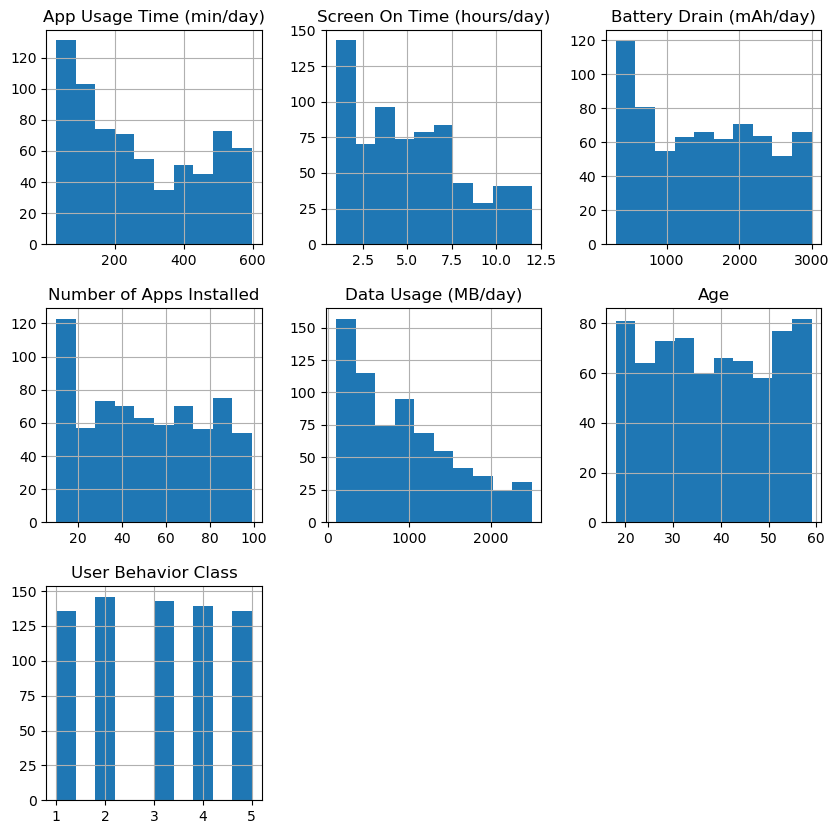

In [196]:
user_behavior.hist(figsize=(10, 10))

After doing EDA, we use the preprocessor class to process our data. The preprocessor class includes the hot encoder, automatic target (and mapping) 

In [197]:
features, target, columns = Preprocessor(user_behavior, "User Behavior Class").hot_encoder(["Device Model", "Operating System", "Gender"]).minmaxscaler(["App Usage Time (min/day)", "Screen On Time (hours/day)", "Battery Drain (mAh/day)", "Number of Apps Installed", "Data Usage (MB/day)", "Age"]).endpoint()

All features have been preprocessed :)


Running AutoML Pipeline...

Started KNN
---------
KNN Regression Stats: 
Best n_neighbors (smallest MAE): 1
Best MAE: 0.0075
Train score at best n_neighbors: 1.0000
Test score at best n_neighbors: 0.9961


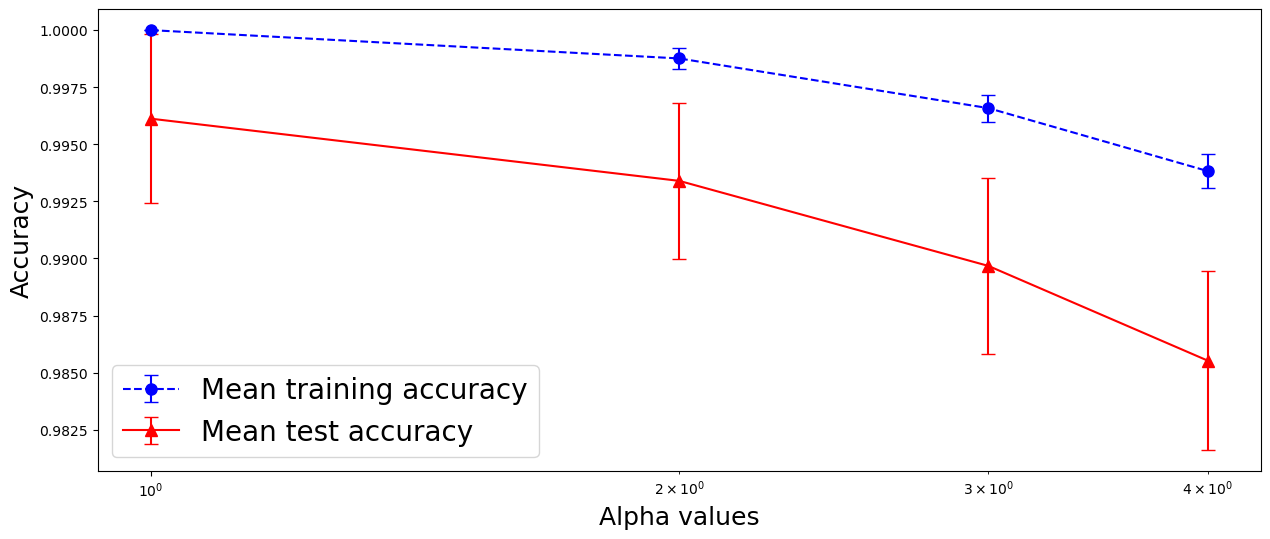

KNN Hyperparameter Tuning took 0.77 seconds

Started Linear regression
---------
Linear regression stats: 
TRAIN SET: Mean = 0.9848634455751227  Stdev = 0.0004836822639168586
 TEST SET: Mean = 0.9834070813781639  Stdev = 0.0015621483981151
Linear Regression took 0.66 seconds

Started ridge regression


KeyboardInterrupt: 

In [198]:
MLmodelsRegressors(features, target).auto_test(30, range(1, 5))

Running AutoML Pipeline...

Started Logistic Regression
---------
Logistic regression stats: 
 TRAIN SET: Mean = 1.0  Stdev = 0.0
 TEST SET: Mean = 0.9992246949030871  Stdev = 0.001447327006233316

Best C: 100.0


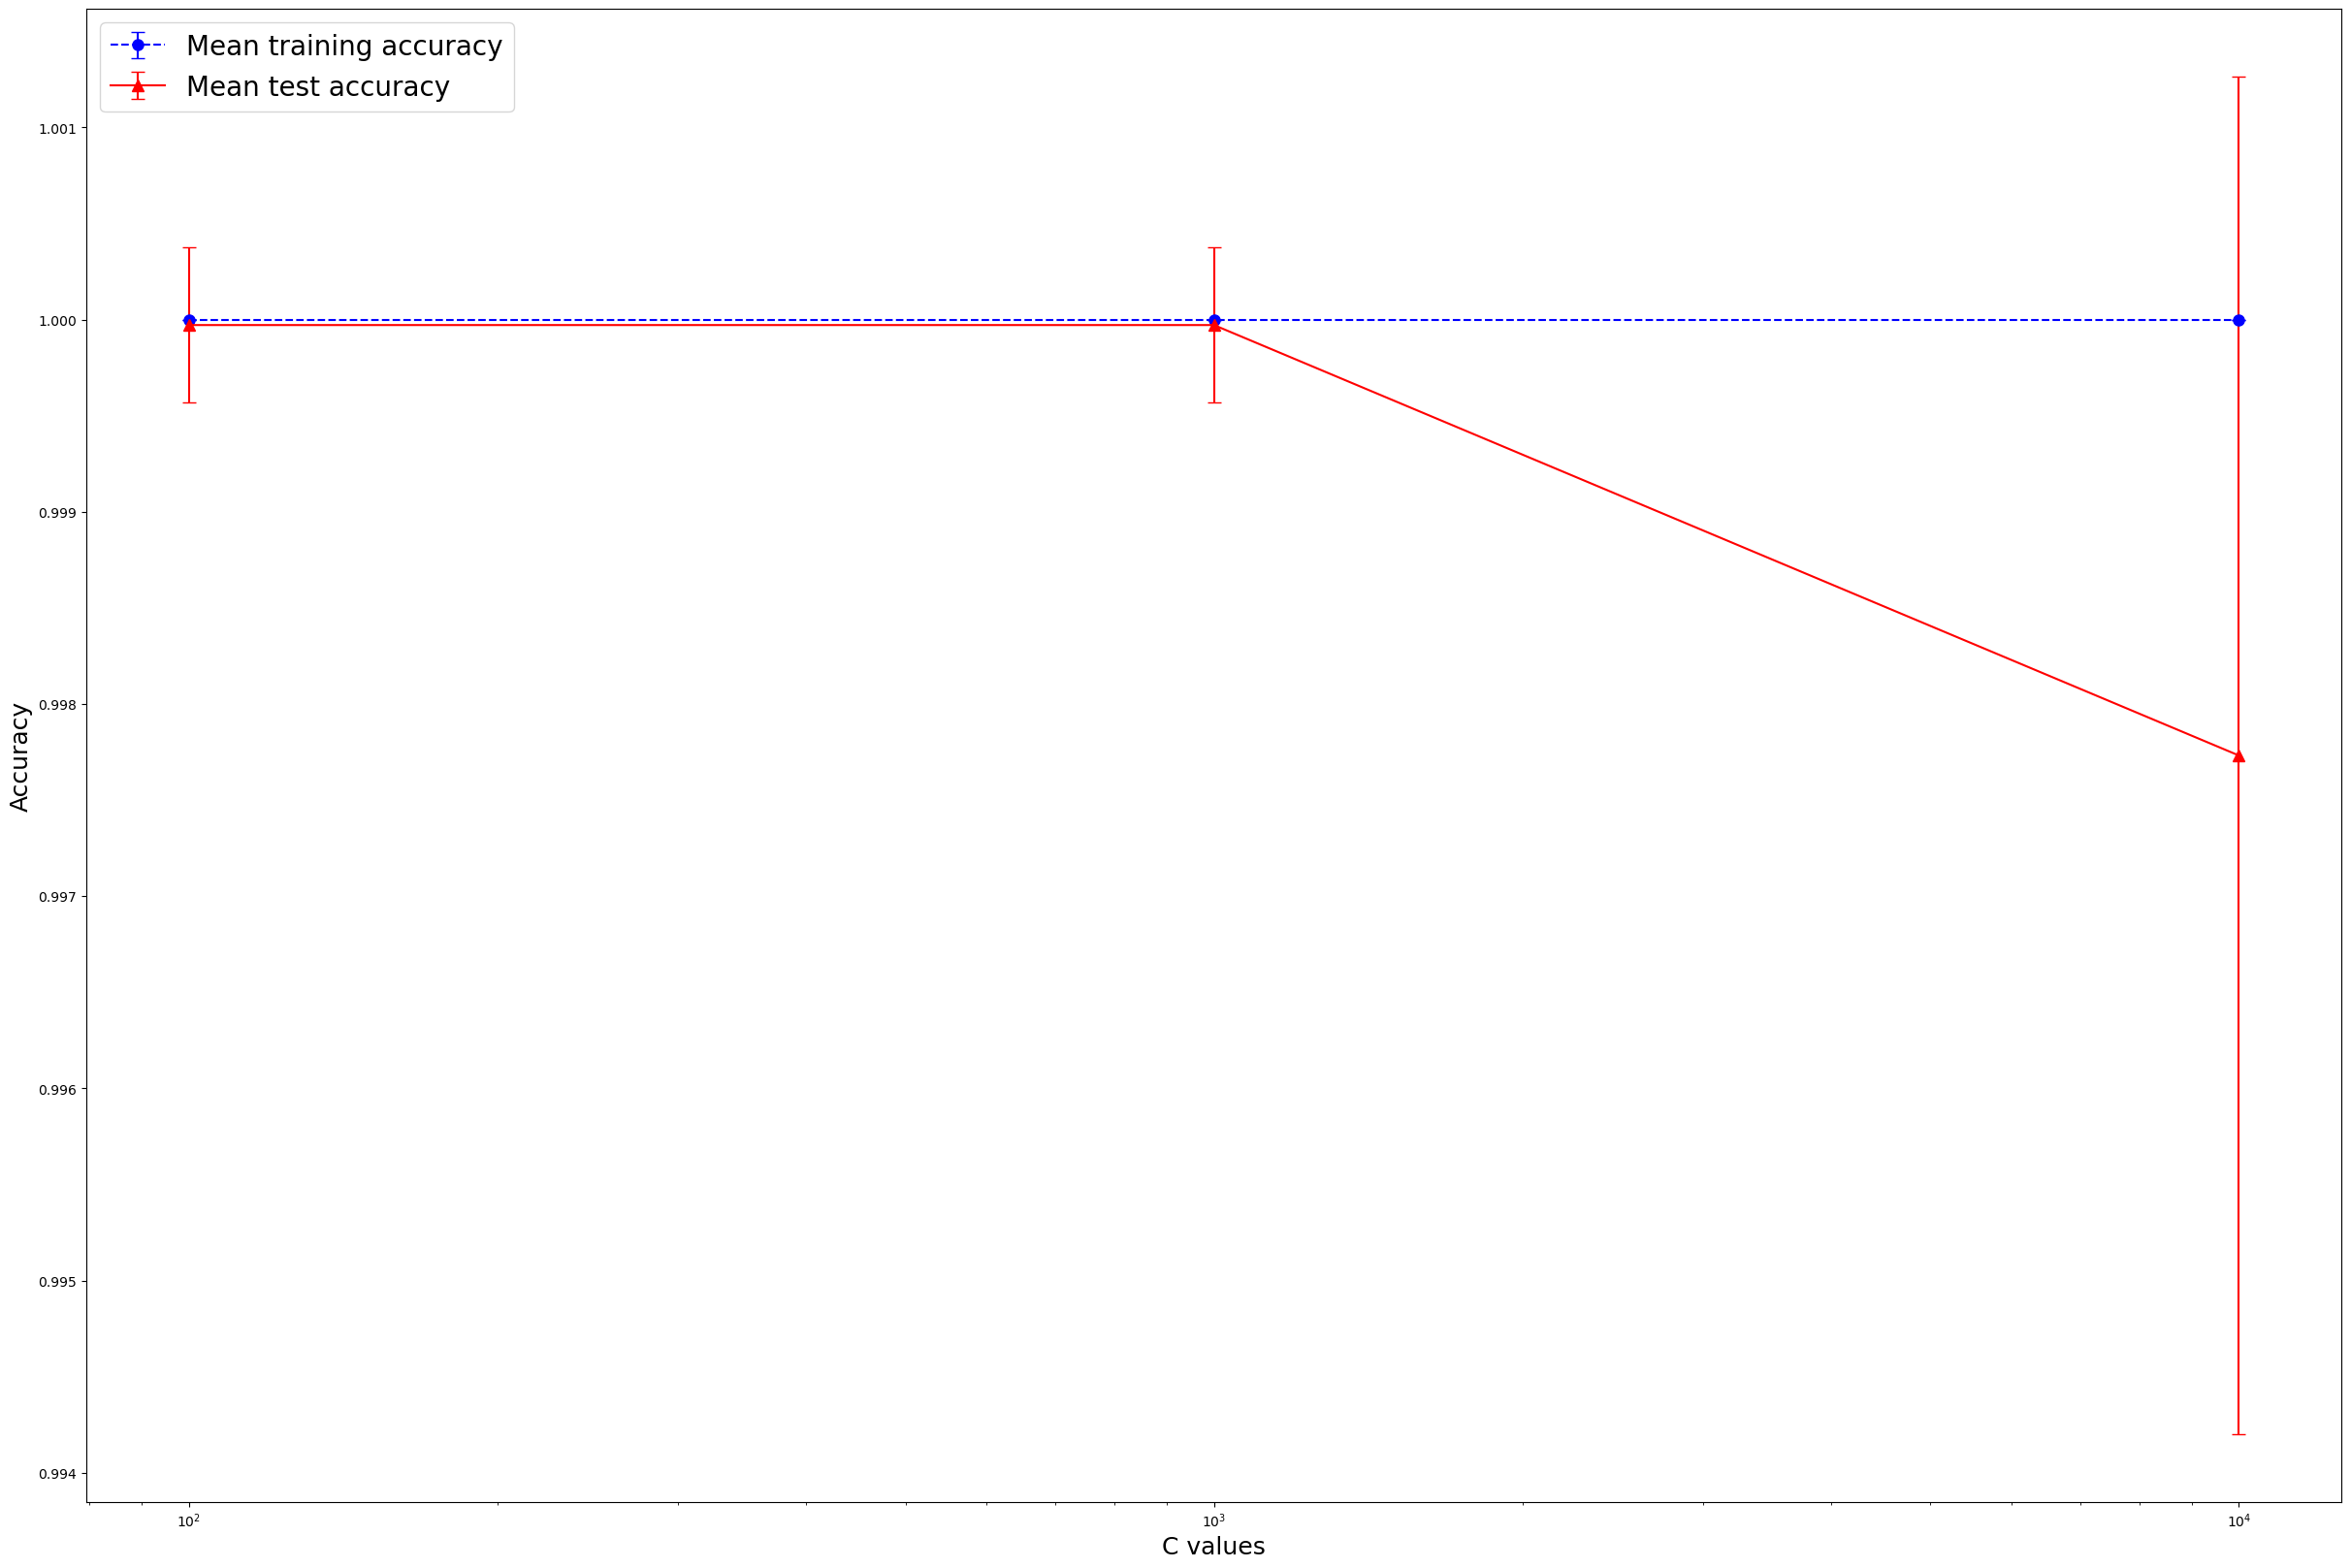

Highest coefficient magnitude for best C:  24.252447450378266
For coefficient:  3


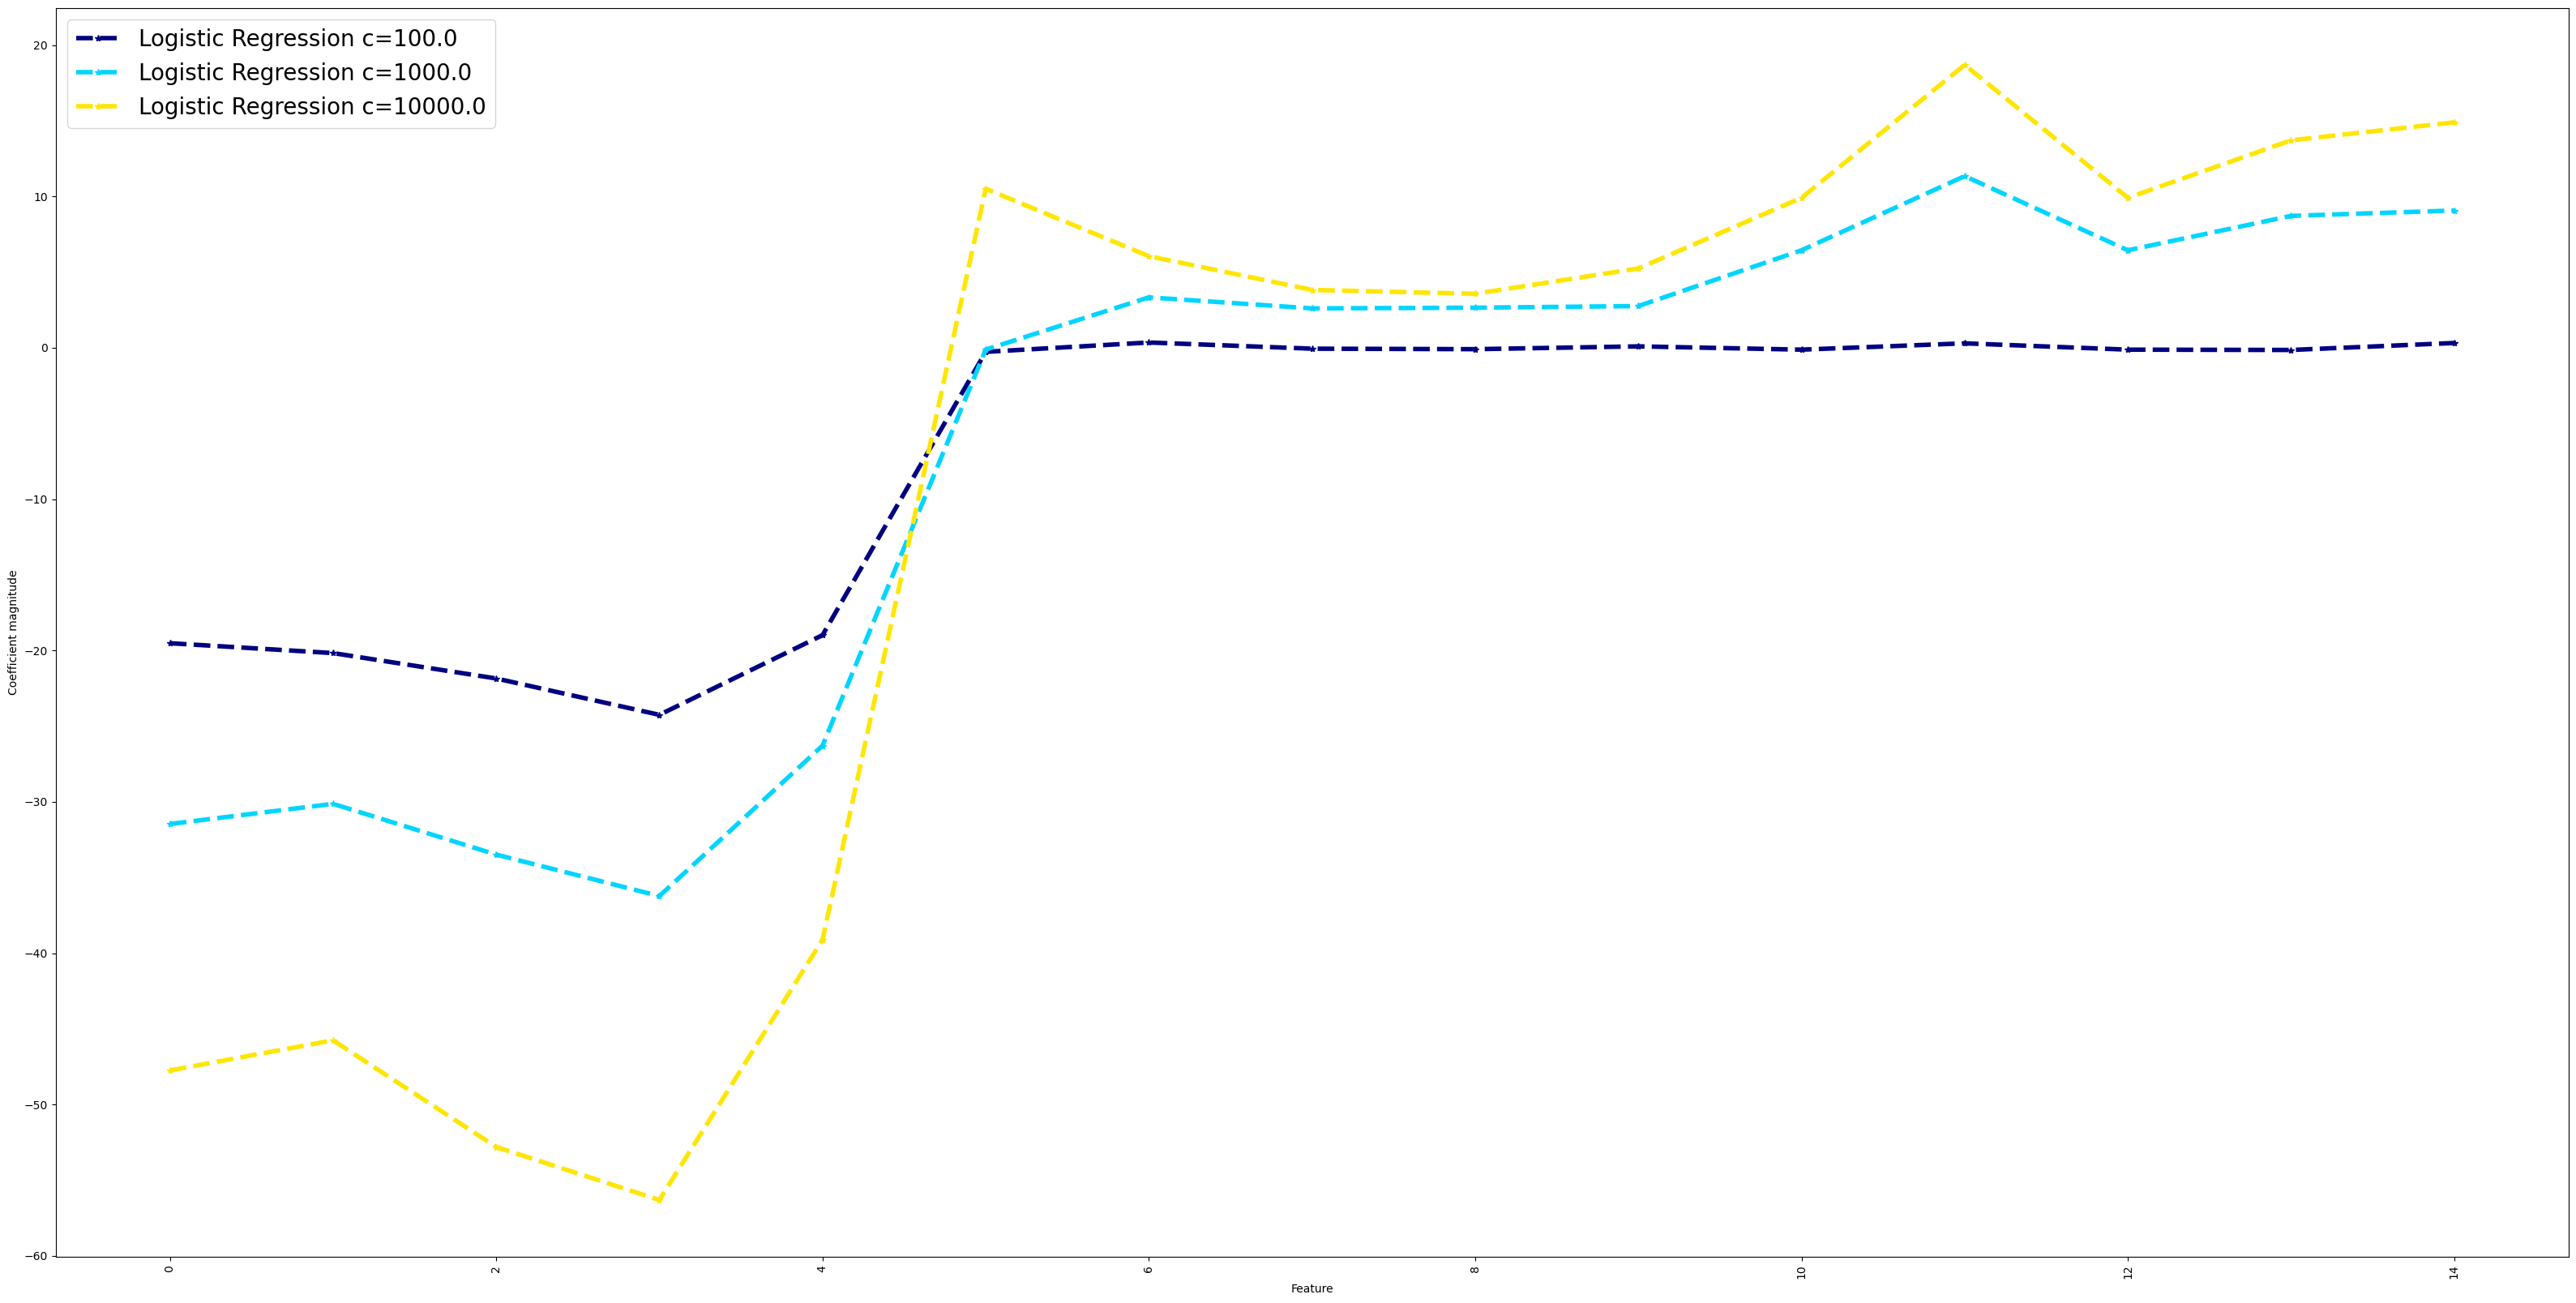

Logistic regression took 11.95 seconds

Started Linear SVC l1
---------
Linear SVC classification stats: 
 TRAIN SET: Mean = 0.8392278854590417  Stdev = 0.009904783131867352
 TEST SET: Mean = 0.8052261306532662  Stdev = 0.03233496437443278

Best C: 100.0


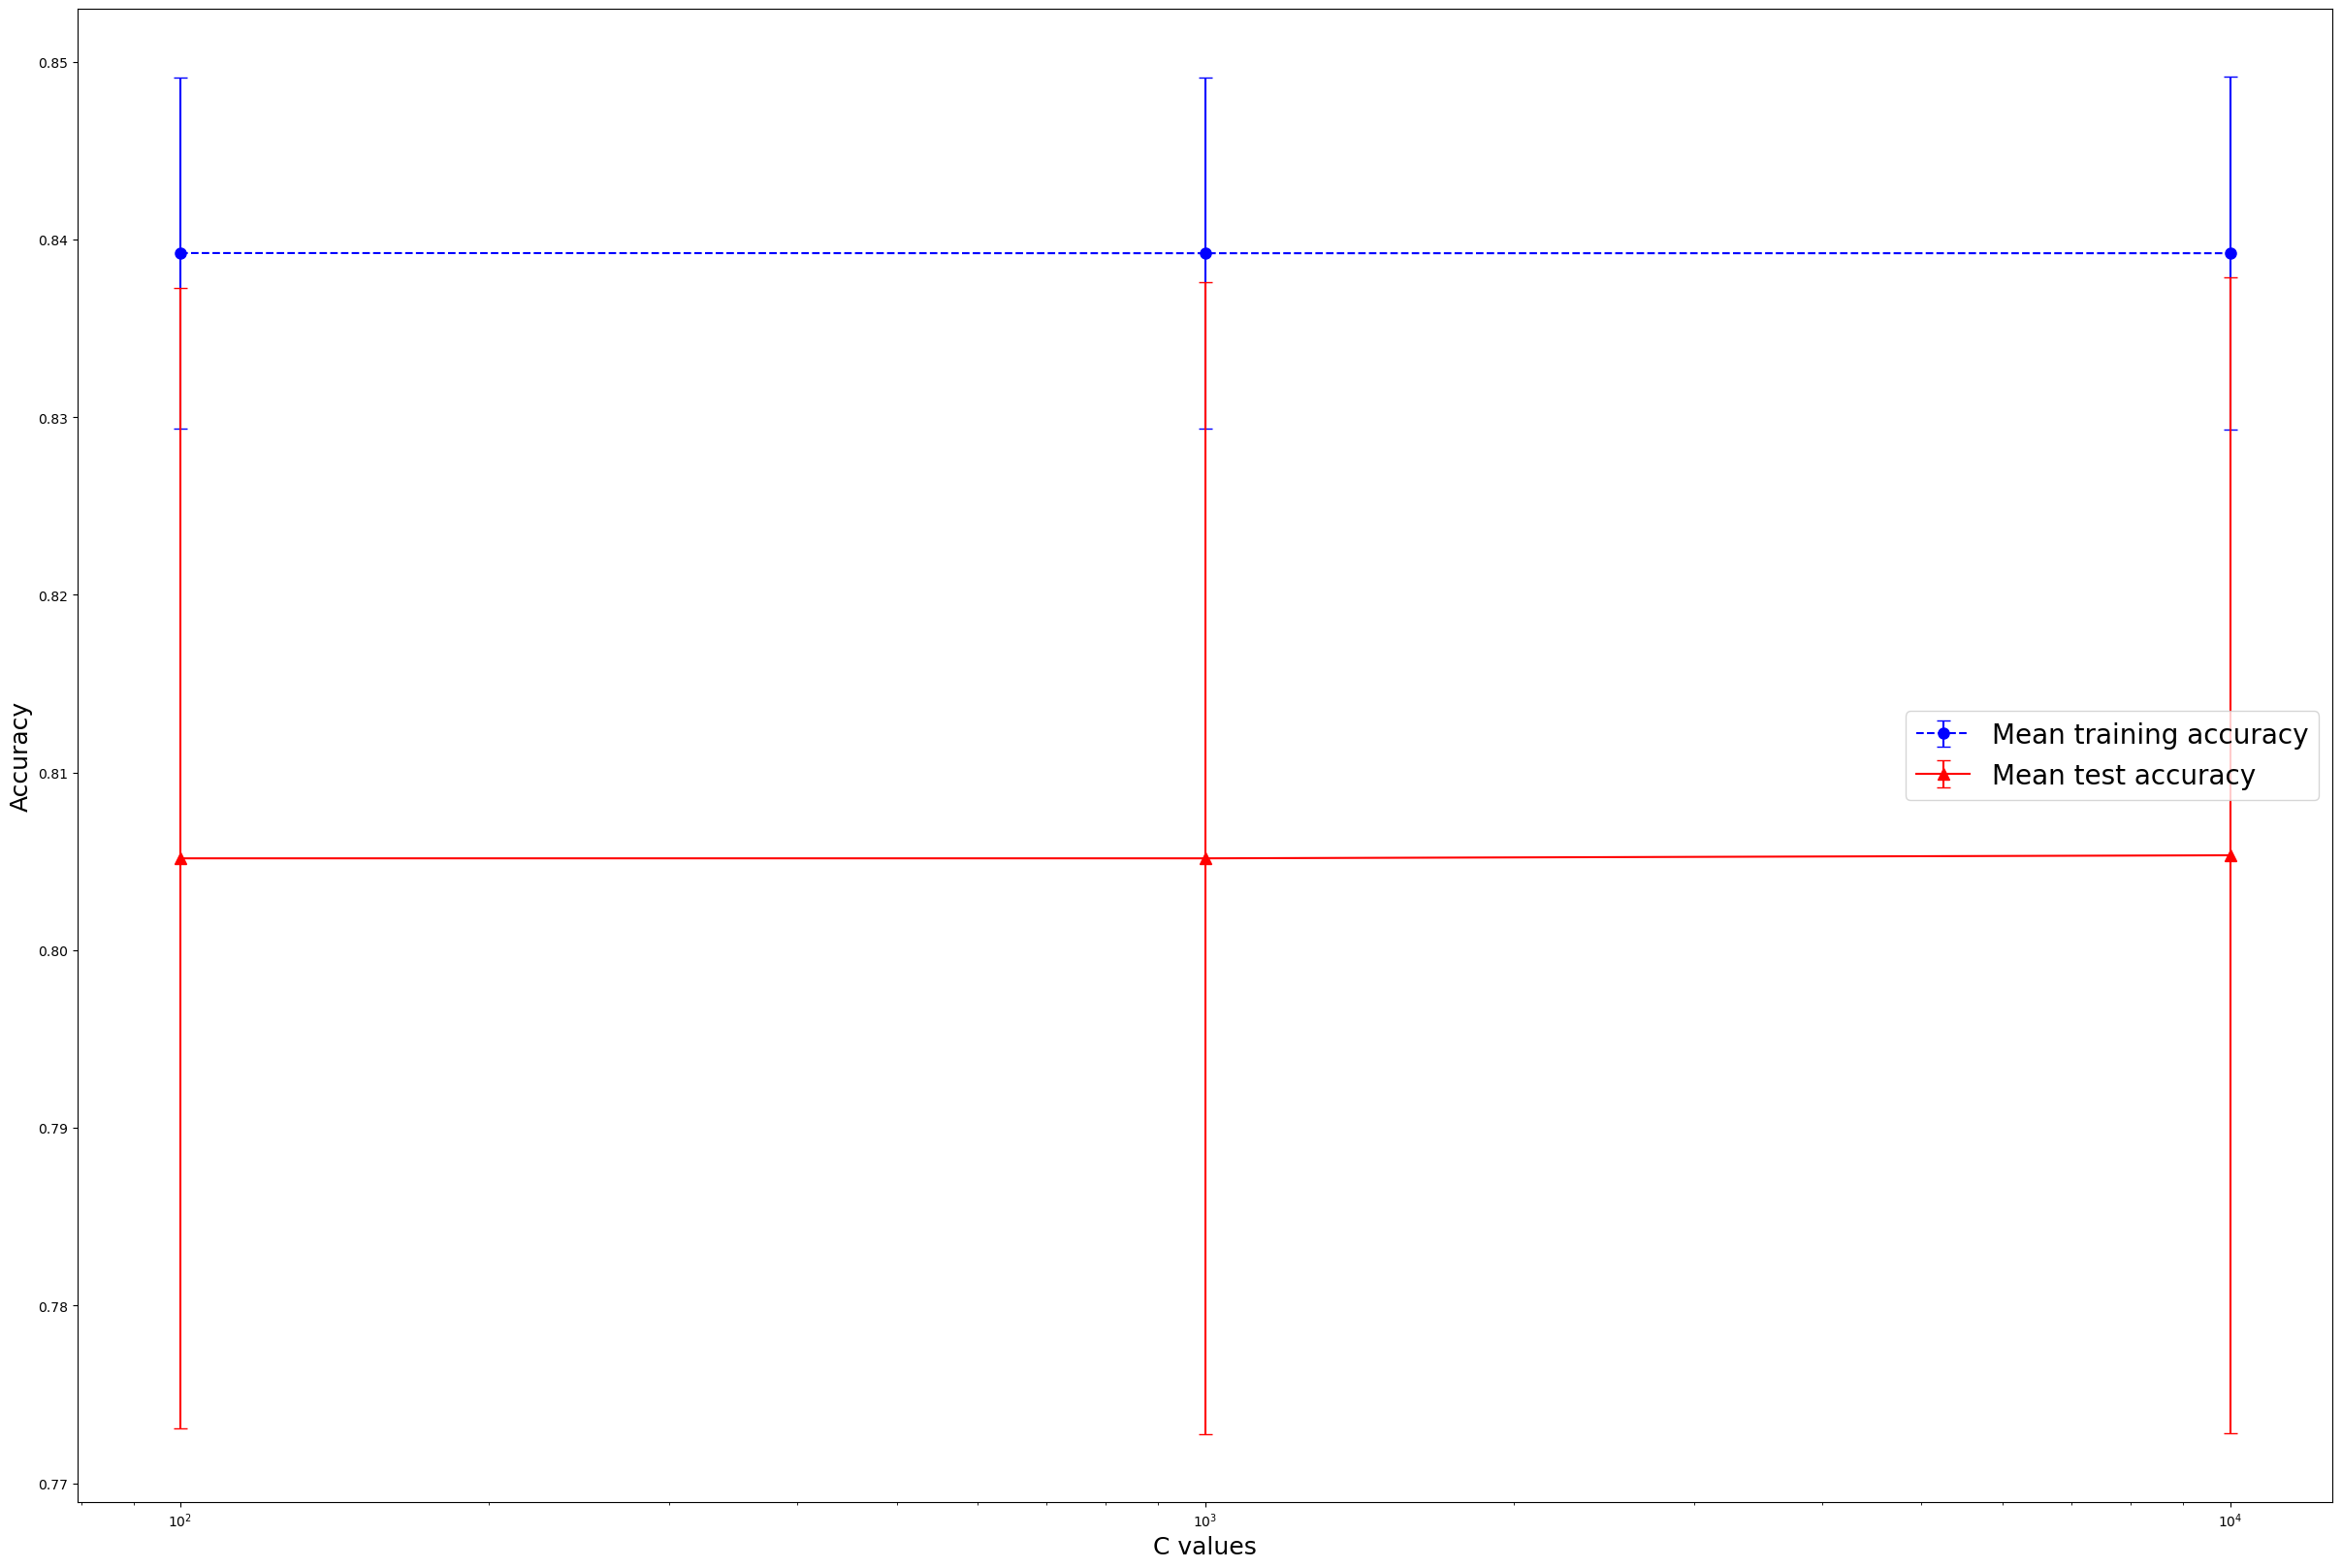

Highest coefficient magnitude for best C:  24.252447450378266
For coefficient:  3


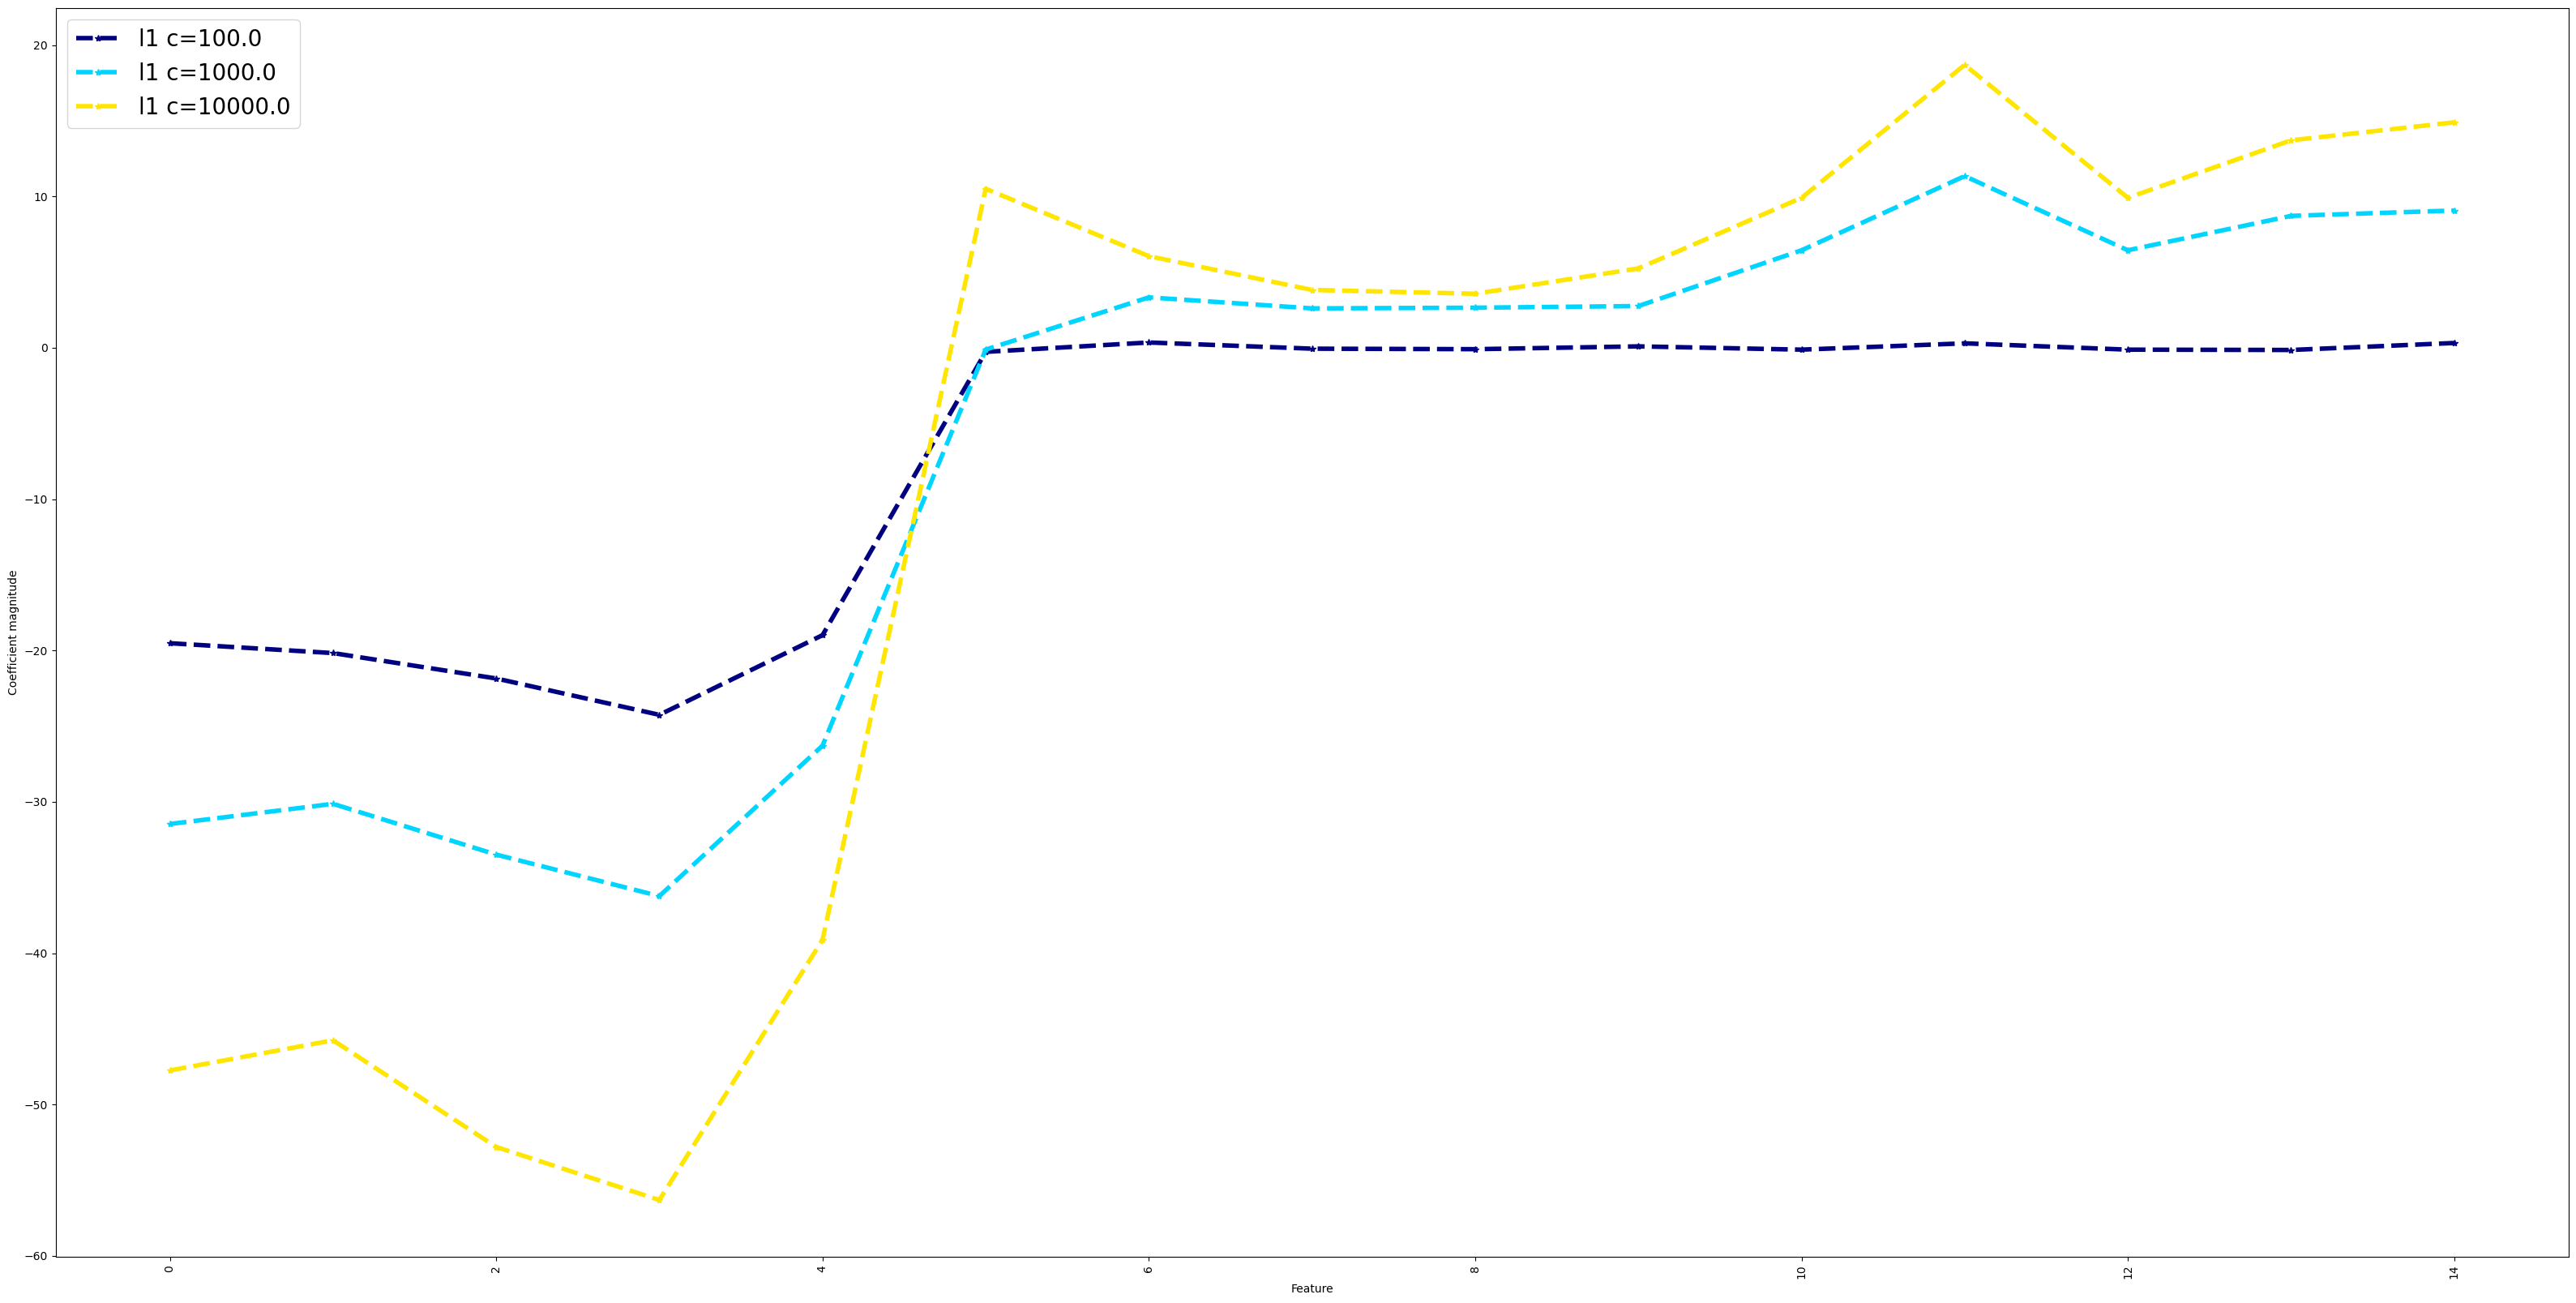

Linear SVC l1 took 24.11 seconds

Started Linear SVC l2
---------
Linear SVC classification stats: 
 TRAIN SET: Mean = 0.8393076493579011  Stdev = 0.009912494799981783
 TEST SET: Mean = 0.8056185690356547  Stdev = 0.032285259606162624

Best C: 100.0


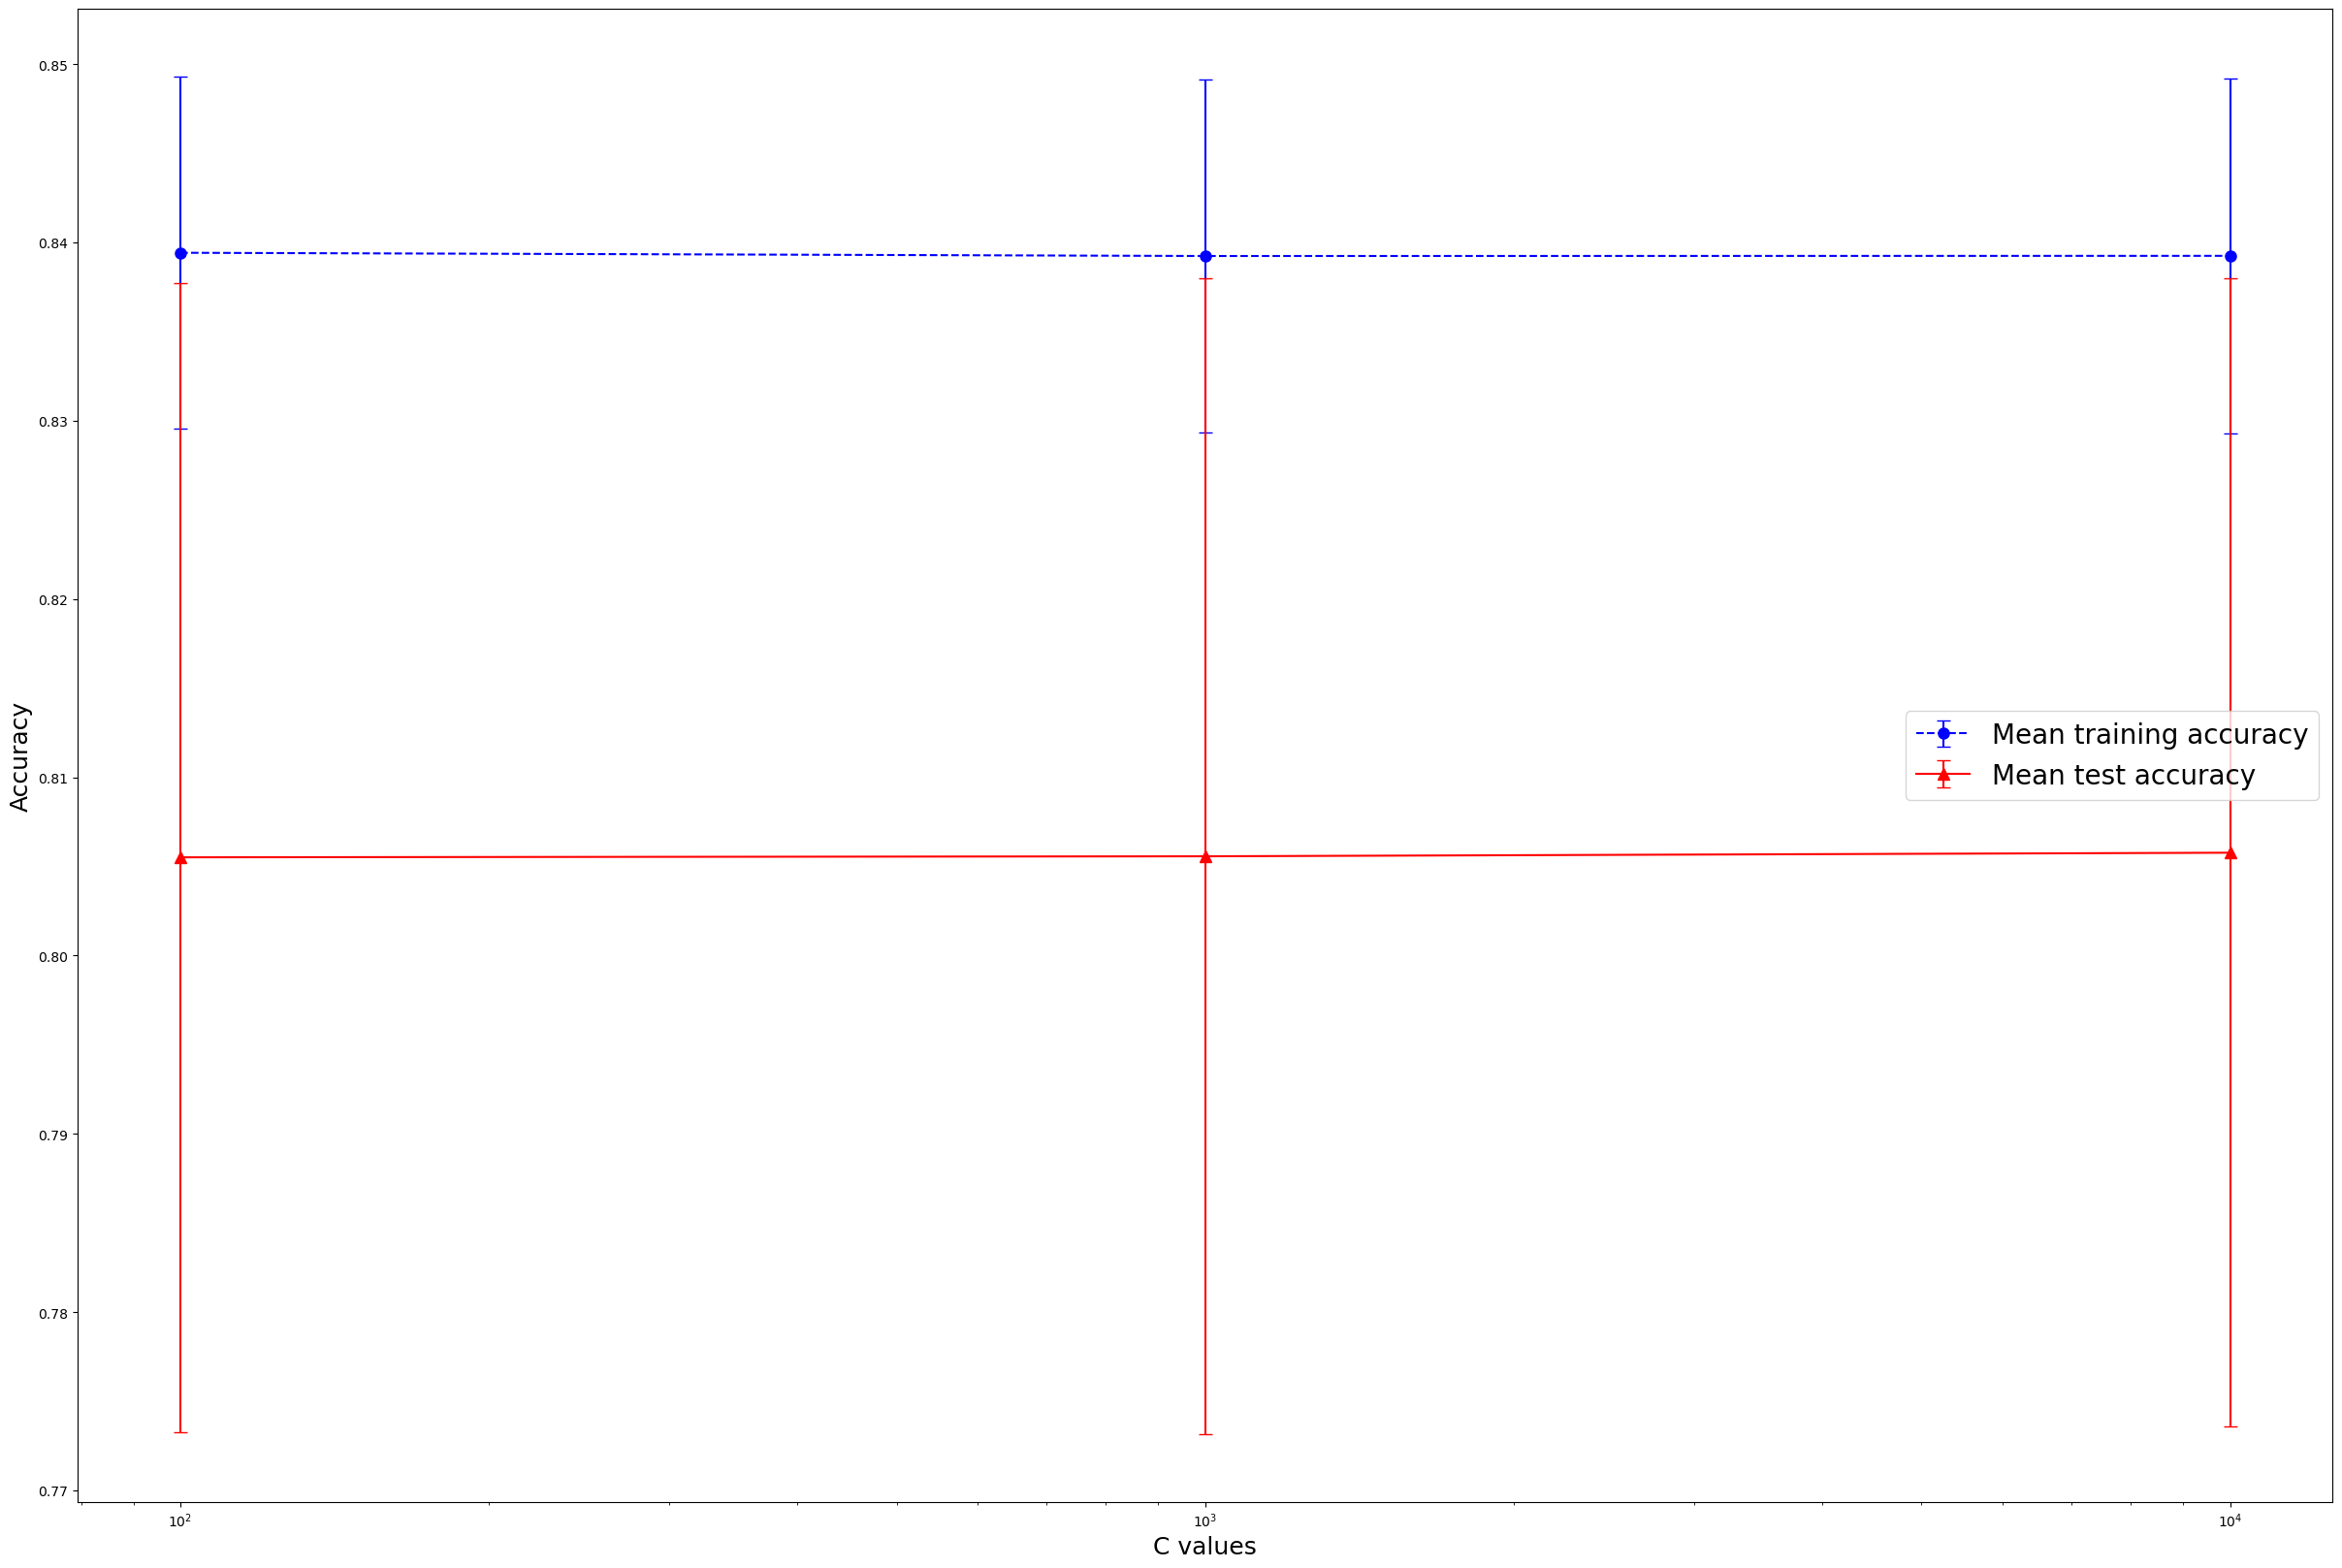

Highest coefficient magnitude for best C:  24.252447450378266
For coefficient:  3


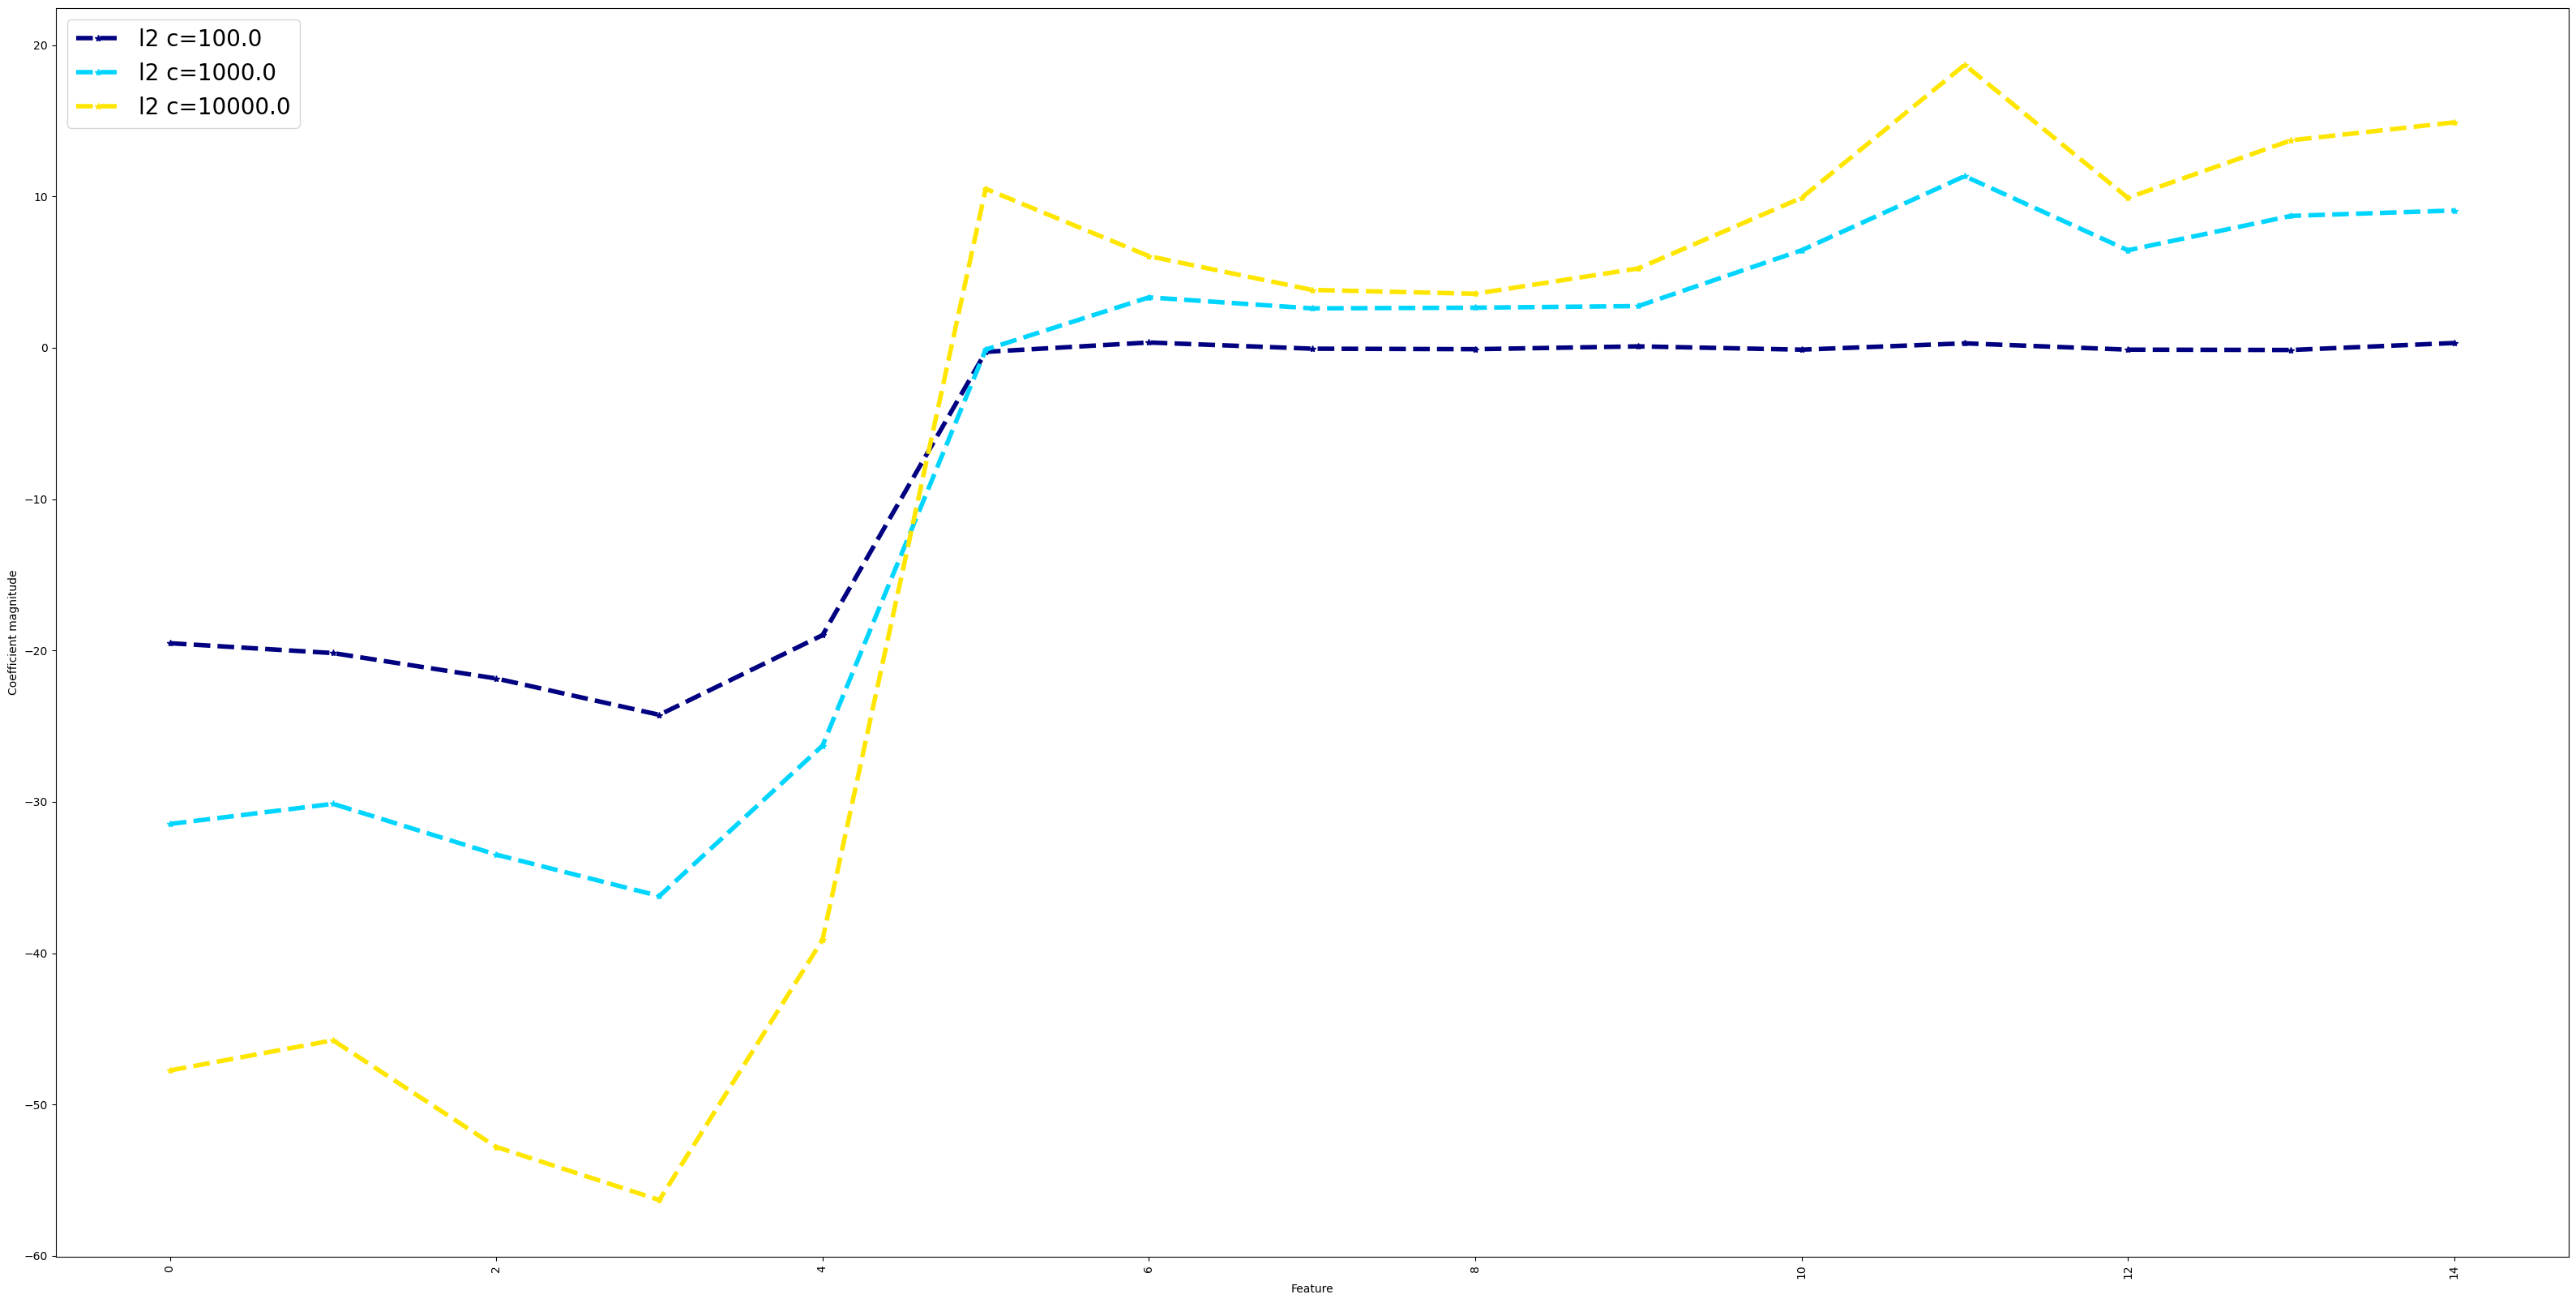

Linear SVC l2 took 5.14 seconds

Started KNN Classifier
---------
KNN Classification Stats: 
Best n_neighbors: 1
Train score at best n_neighbors: 1.0000
Test score at best n_neighbors: 0.9904


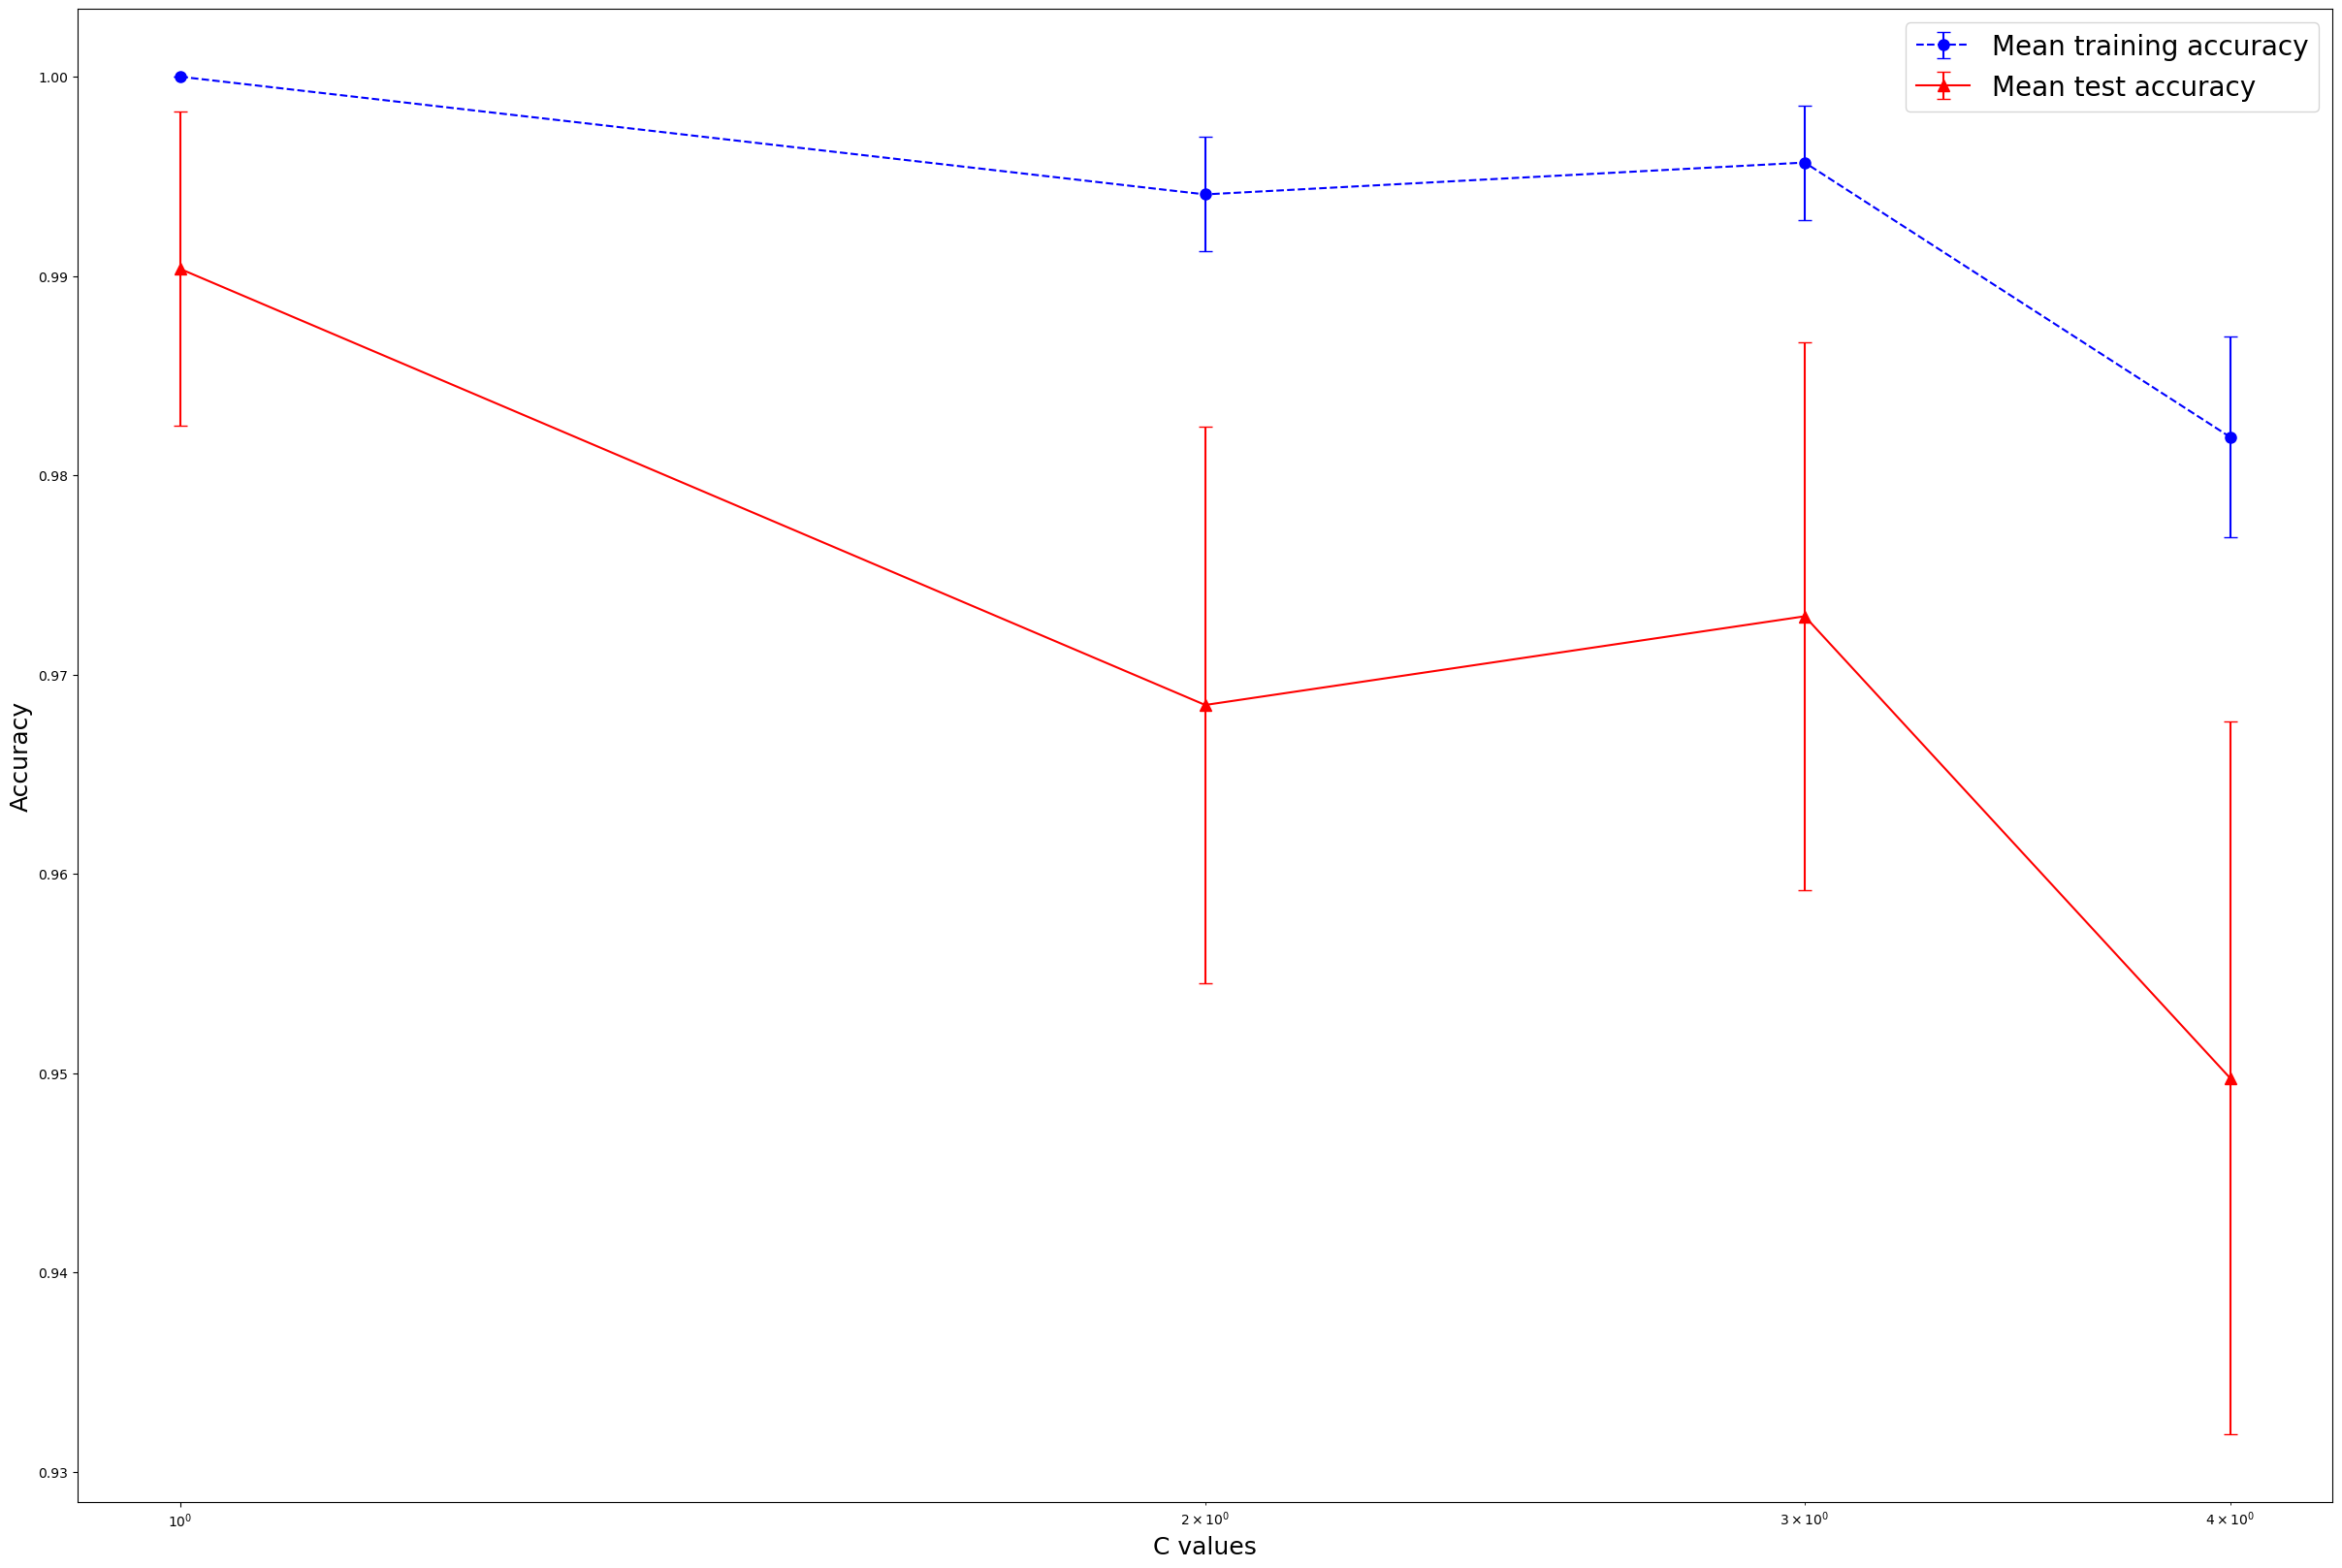

KNN Classifier took 9.47 seconds

----- Summary of Execution Times -----
Logistic Regression: 11.95 seconds
Linear SVC l1: 24.11 seconds
Linear SVC l2: 5.14 seconds
KNN Classifier: 9.47 seconds
-------------------------------------------


(      1   2   3   4   5   6   7   8   9   10   ... 190 191 192 193 194 195  \
 100     1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
 1,000   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
 1e+04   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   
 
       196 197 198 199  
 100     1   1   1   1  
 1,000   1   1   1   1  
 1e+04   1   1   1   1  
 
 [3 rows x 199 columns],
       1   2   3      4   5   6   7   8      9   10   ...    190    191    192  \
 100     1   1   1      1   1   1   1   1      1   1  ...      1      1      1   
 1,000   1   1   1      1   1   1   1   1      1   1  ...      1      1      1   
 1e+04   1   1   1 0.9943   1   1   1   1 0.9943   1  ... 0.9943 0.9943 0.9886   
 
          193 194    195 196 197    198 199  
 100        1   1      1   1   1      1   1  
 1,000      1   1      1   1   1      1   1  
 1e+04 0.9943   1 0.9943   1   1 0.9943   1  
 
 [3 rows x 199 columns],
    seed_1  se

In [205]:
MLmodelsClassifiers(features, target).auto_test(200, range(1, 5), set_C=[1e2, 1e3, 1e4])

In [206]:
diamonds_df = pd.read_csv("diamonds.csv")
diamonds_df.drop(columns=['Unnamed: 0'], inplace=True)
diamonds_df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58,334,4.2,4.23,2.63
4,0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57,2757,5.75,5.76,3.5
53936,0.72,Good,D,SI1,63.1,55,2757,5.69,5.75,3.61
53937,0.7,Very Good,D,SI1,62.8,60,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61,58,2757,6.15,6.12,3.74


array([[<Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>,
        <Axes: title={'center': 'table'}>],
       [<Axes: title={'center': 'price'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

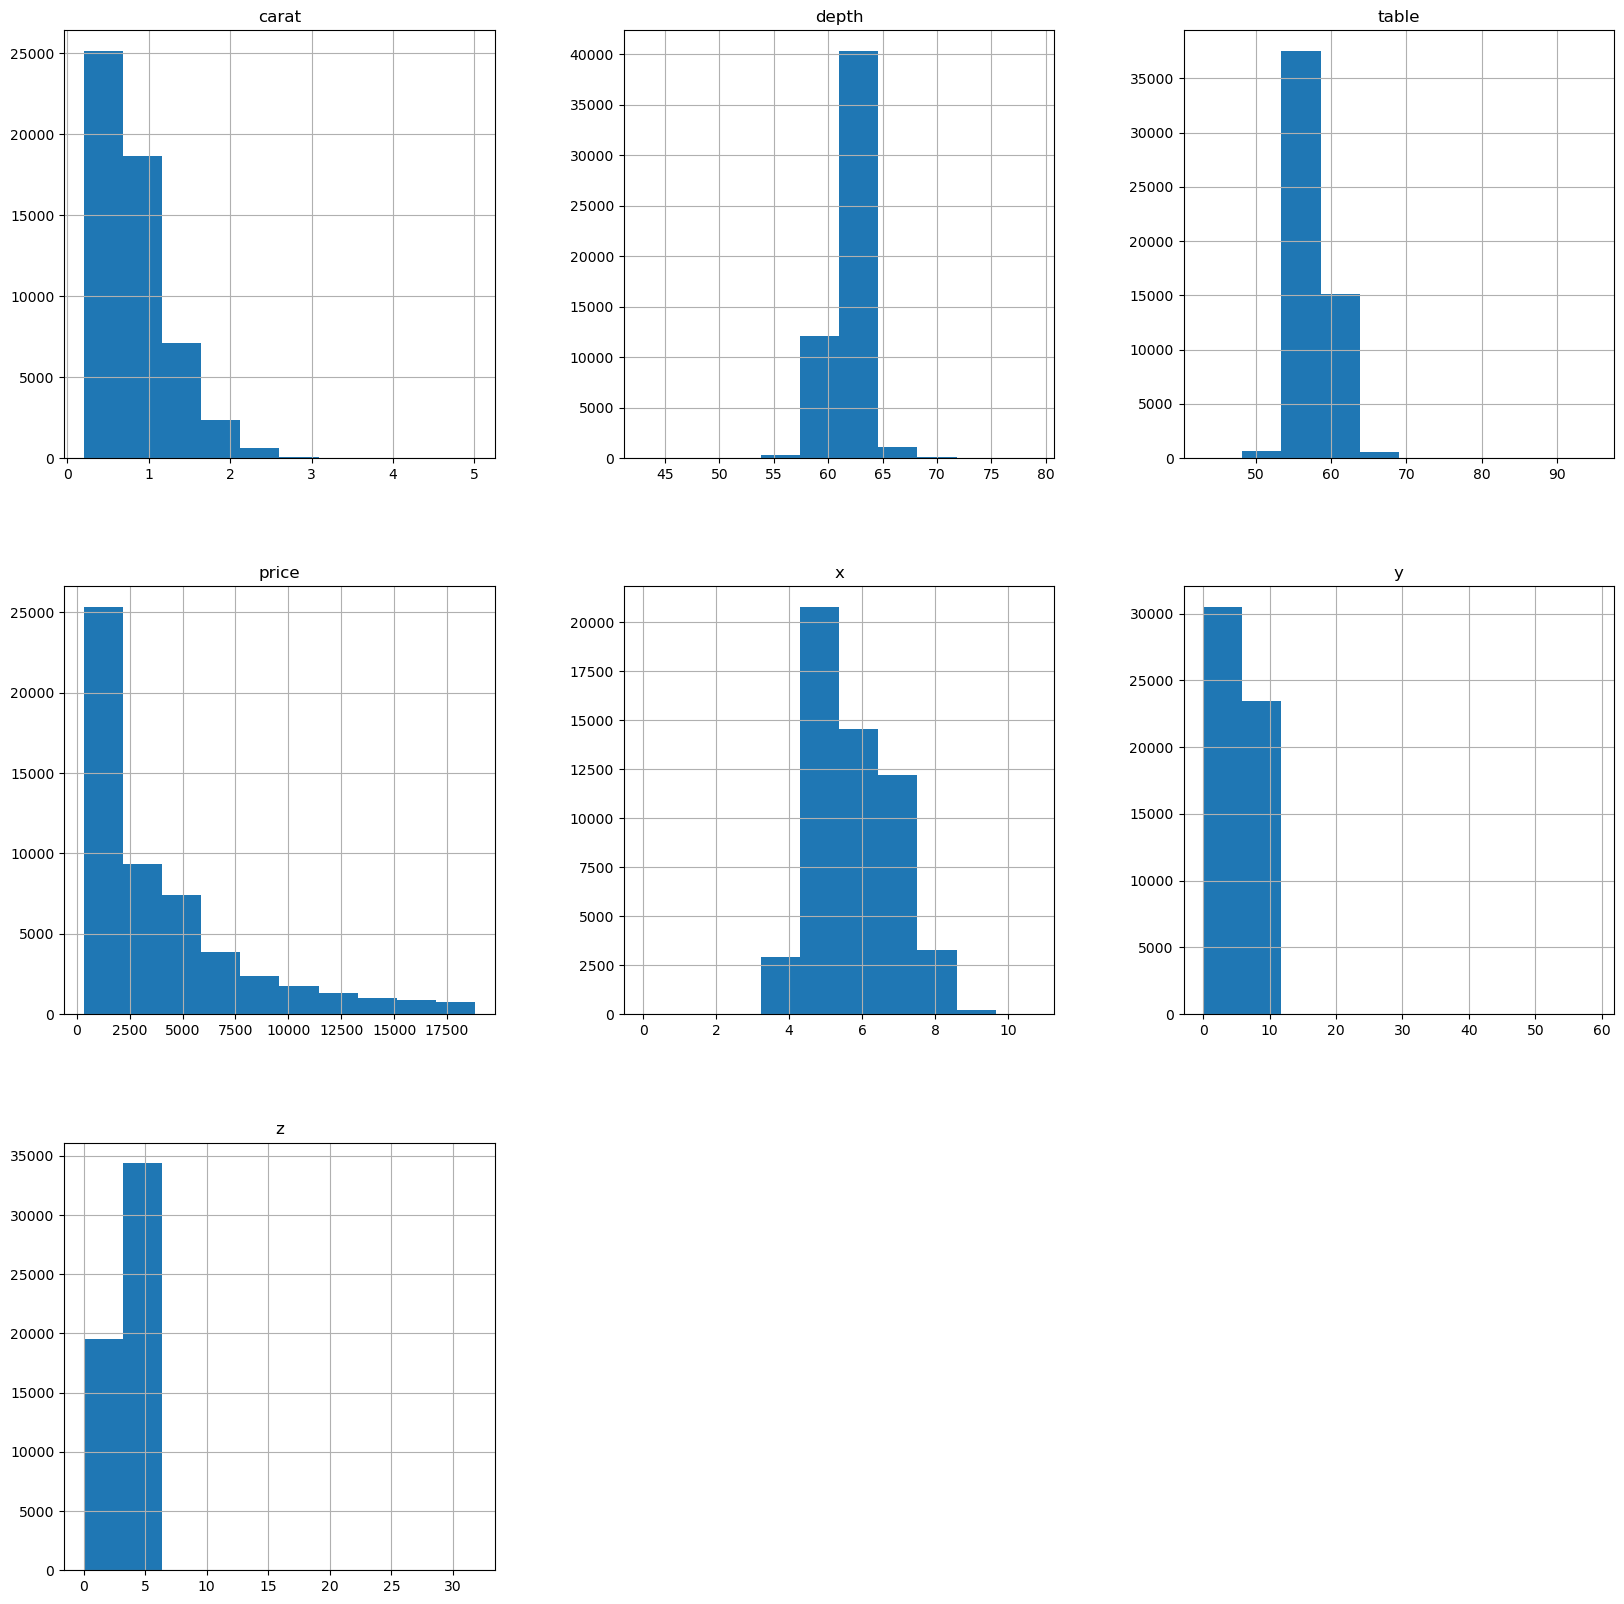

In [209]:
diamonds_df.hist(figsize=(20, 20))

Looking at the data, cut, color and clarity will need ordinal mapping, carat, depth, table, and x, y, z will need z scaling. They can all show somewhat normally distributed data, with the only exception being that there are outliers in the dataset. Hence, we don't want to use minmax. 



In [210]:
mapping_dict = {"color":{"D":1,
                       "E":2,
                       "F":3,
                       "G":4,
                       "H":5,
                       "I":6,
                       "J":7},
                "clarity":{"IF":1,
                           "VVS1":2,
                           "VVS2":3,
                           "VS1":4,
                           "VS2":5,
                           "SI1":6,
                           "SI2":7,
                           "I1":8},
                "cut":{"Ideal":1,
                       "Premium":2,
                       "Very Good":3,
                       "Good":4,
                       "Fair":5}}
features_df, target, ___ = (
    Preprocessor(diamonds_df, "price")
    .map_ordinal_variables(["color", "clarity", "cut"], mapping_dict)
    .auto_engineer("volume", ["x", "y", "z"], "multiplication") # will need z scaling
    .zscaler(["carat", "depth", "table", "x", "y", "z", "volume"])
    .endpoint()
)

# removed density since it did weird stuff. Same with volume
features_df

The following features have not been preprocessed: volume


array([[-1.19816781, -0.17409151, -1.09967199, ...,  7.        ,
         1.        , -1.17129422],
       [-1.24036129, -1.36073849,  1.58552871, ...,  6.        ,
         2.        , -1.21853297],
       [-1.19816781, -3.38501862,  3.37566251, ...,  4.        ,
         4.        , -1.17289363],
       ...,
       [-0.20662095,  0.73334442,  1.13799526, ...,  6.        ,
         3.        , -0.19681471],
       [ 0.13092691, -0.52310533,  0.24292836, ...,  7.        ,
         2.        ,  0.1395205 ],
       [-0.10113725,  0.31452784, -1.09967199, ...,  7.        ,
         1.        , -0.06749301]])

Running AutoML Pipeline...

Started KNN
---------
KNN Regression Stats: 
Best n_neighbors (smallest MAE): 7
Best MAE: 368.0857
Train score at best n_neighbors: 0.9774
Test score at best n_neighbors: 0.9690


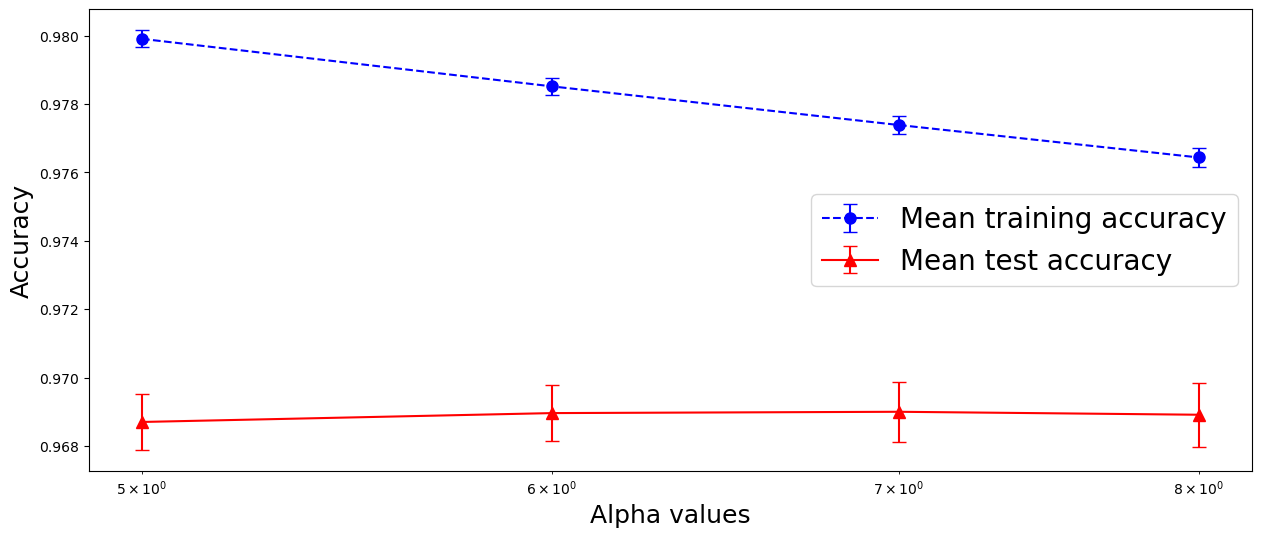

KNN Hyperparameter Tuning took 95.41 seconds

Started Linear regression
---------
Linear regression stats: 
TRAIN SET: Mean = 0.9075289715358449  Stdev = 0.0008916394451280602
 TEST SET: Mean = 0.9004415490026921  Stdev = 0.012524940150305312
Linear Regression took 4.06 seconds

Started ridge regression
---------
Ridge regression stats: 
 TEST SET: R^2 Mean = 0.9004472768449975  Stdev = 0.012721838261766101

Best Alpha: 1e-10


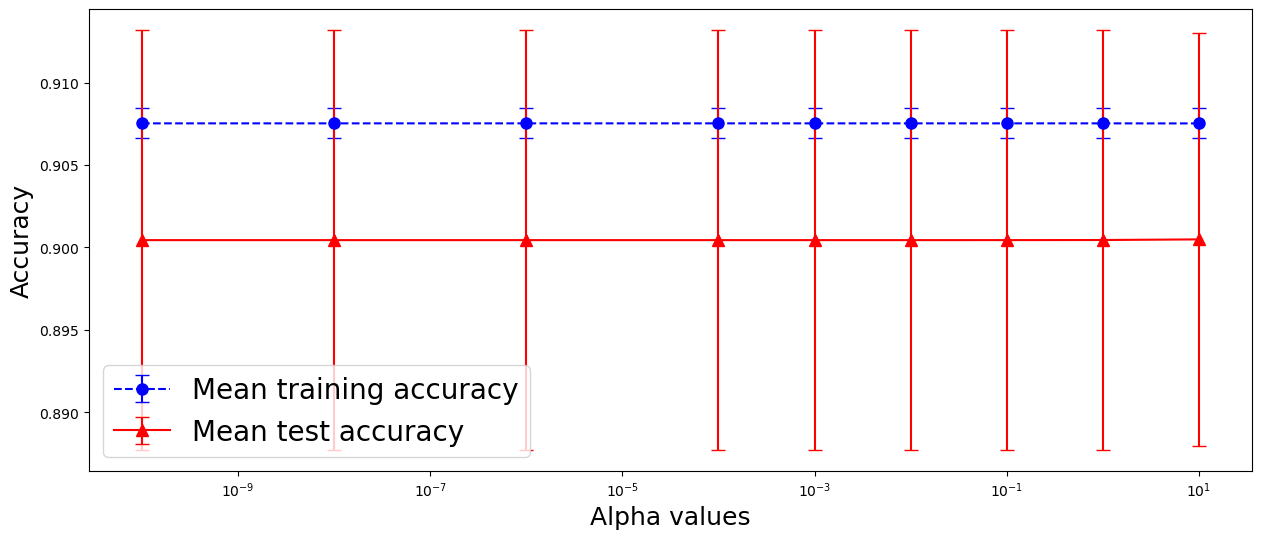

Highest coefficient magnitude for best alpha:  4460.273324833661
For coefficient:  0


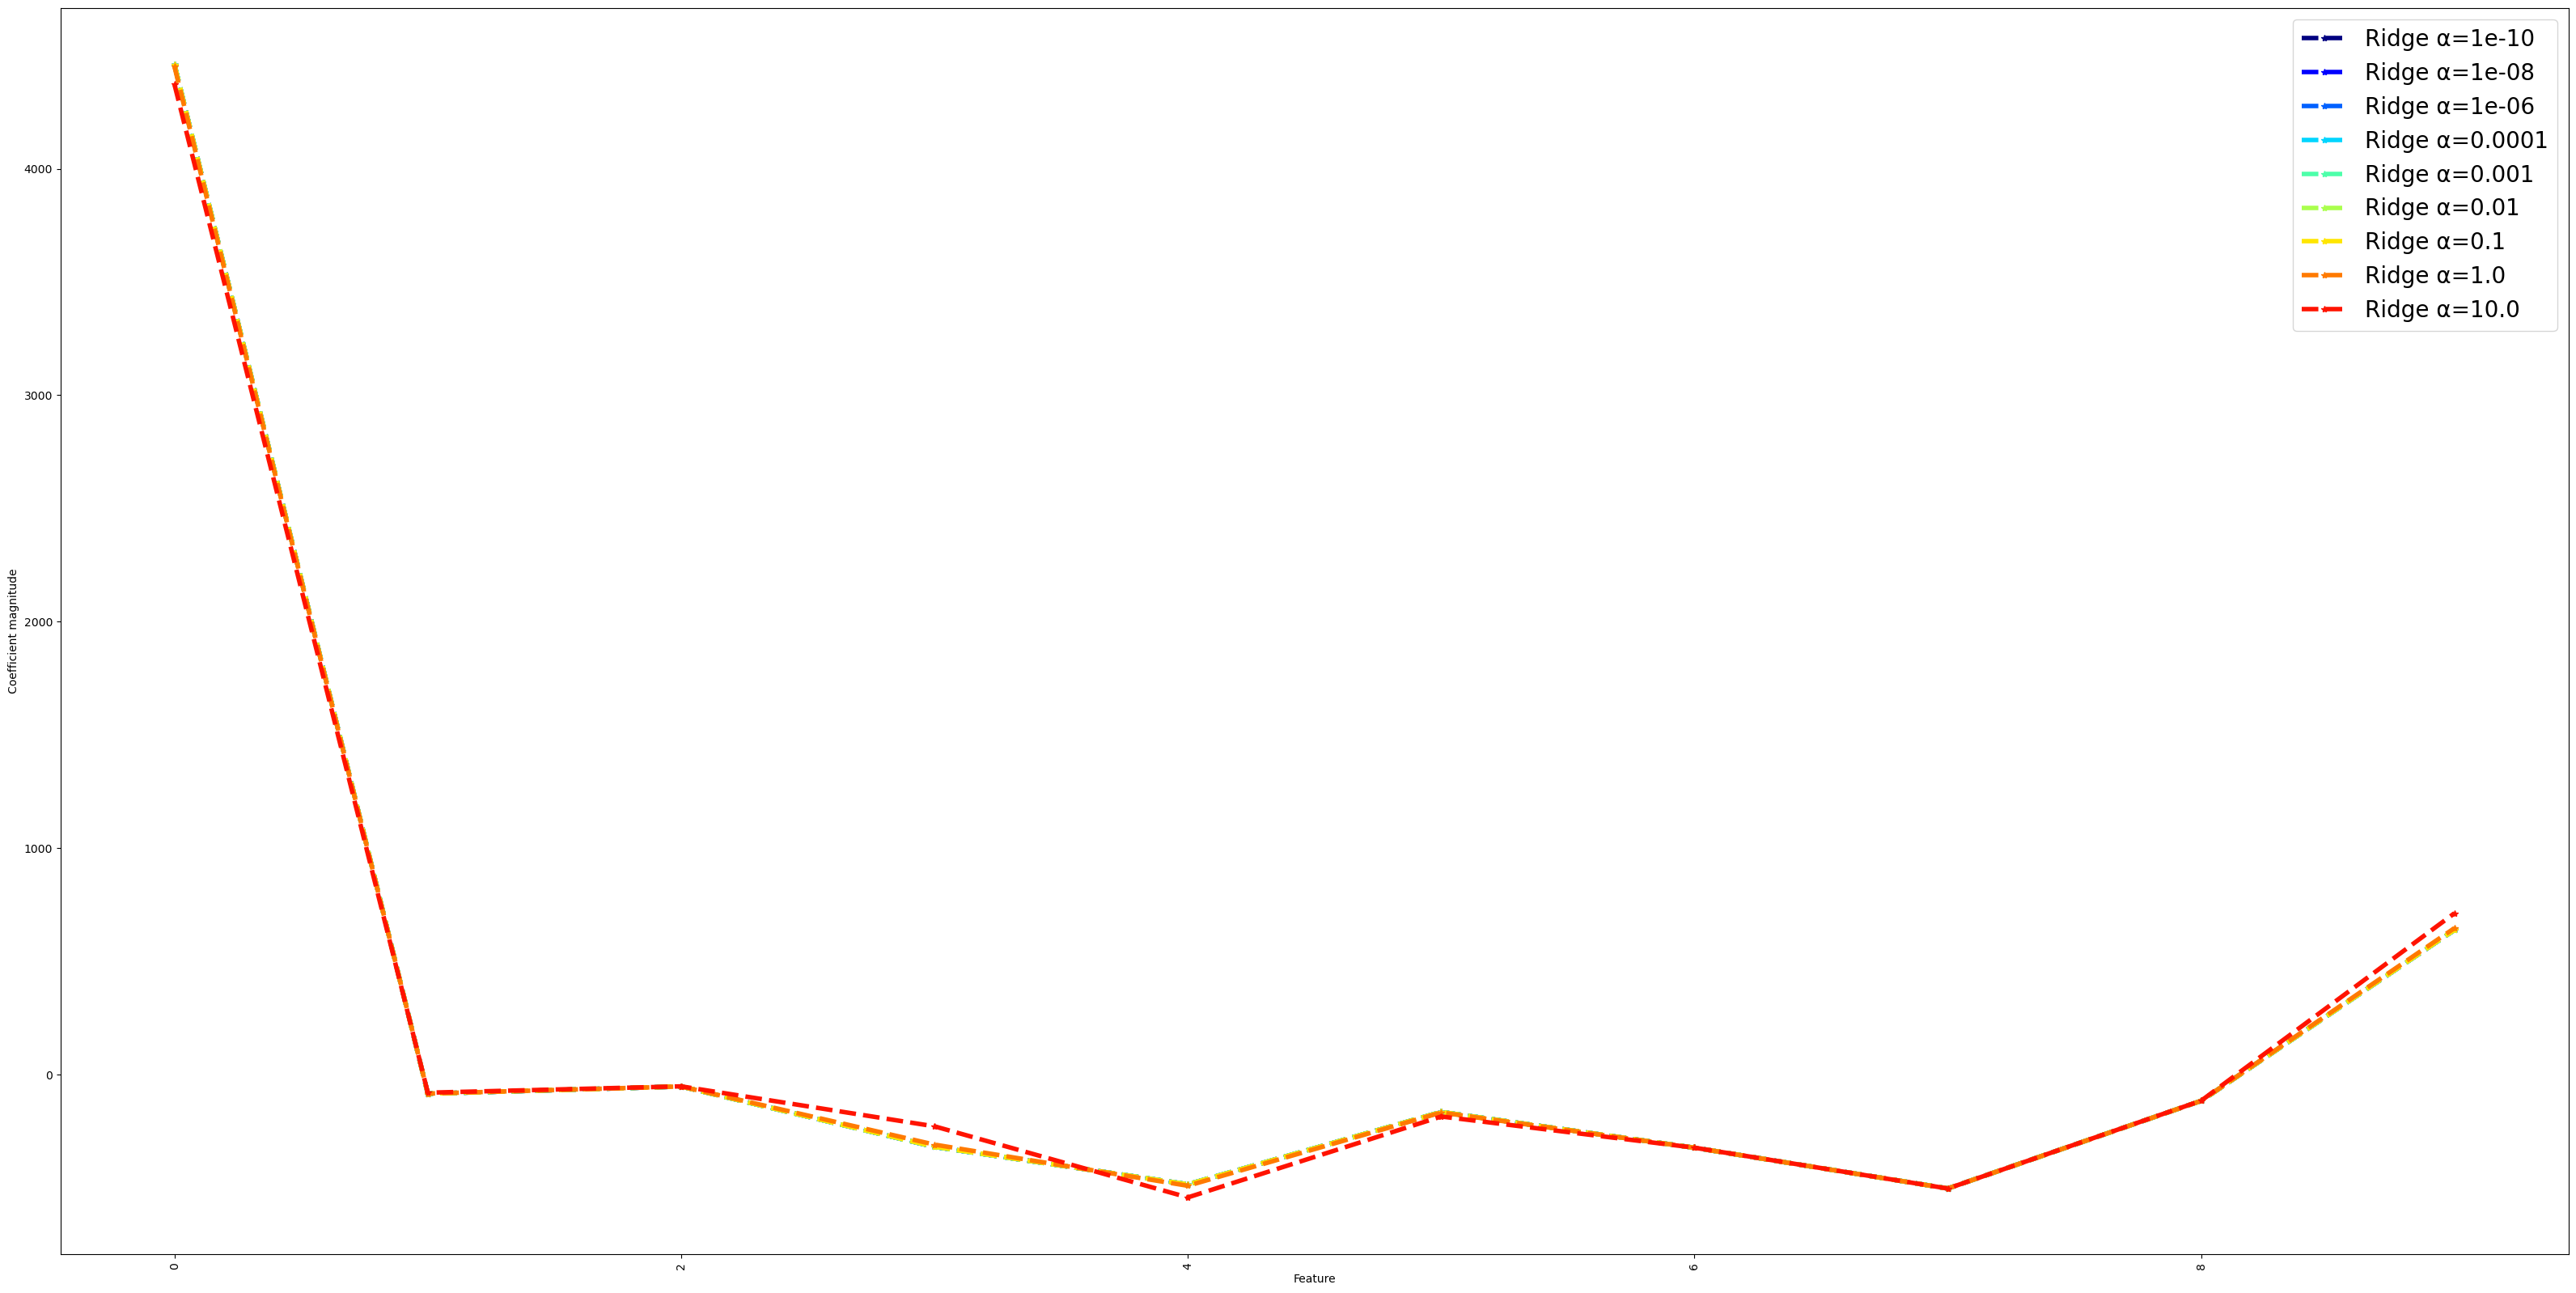

Ridge Regression took 23.13 seconds

---------
Lasso regression stats: 
 TEST SET: R^2 Mean = 0.9008499729504202  Stdev = 0.011808540473107728

Best Alpha: 1e-10


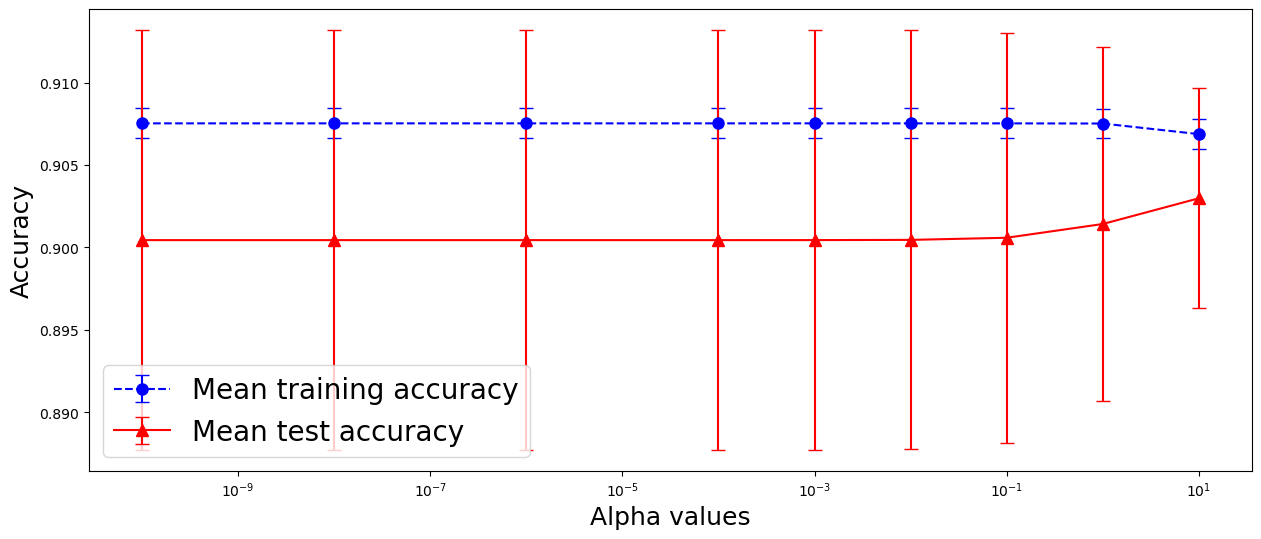

Lasso Regression took 1366.50 seconds

Highest coefficient magnitude for best alpha α=1e-10:  4460.273324830849
For coefficient:  0


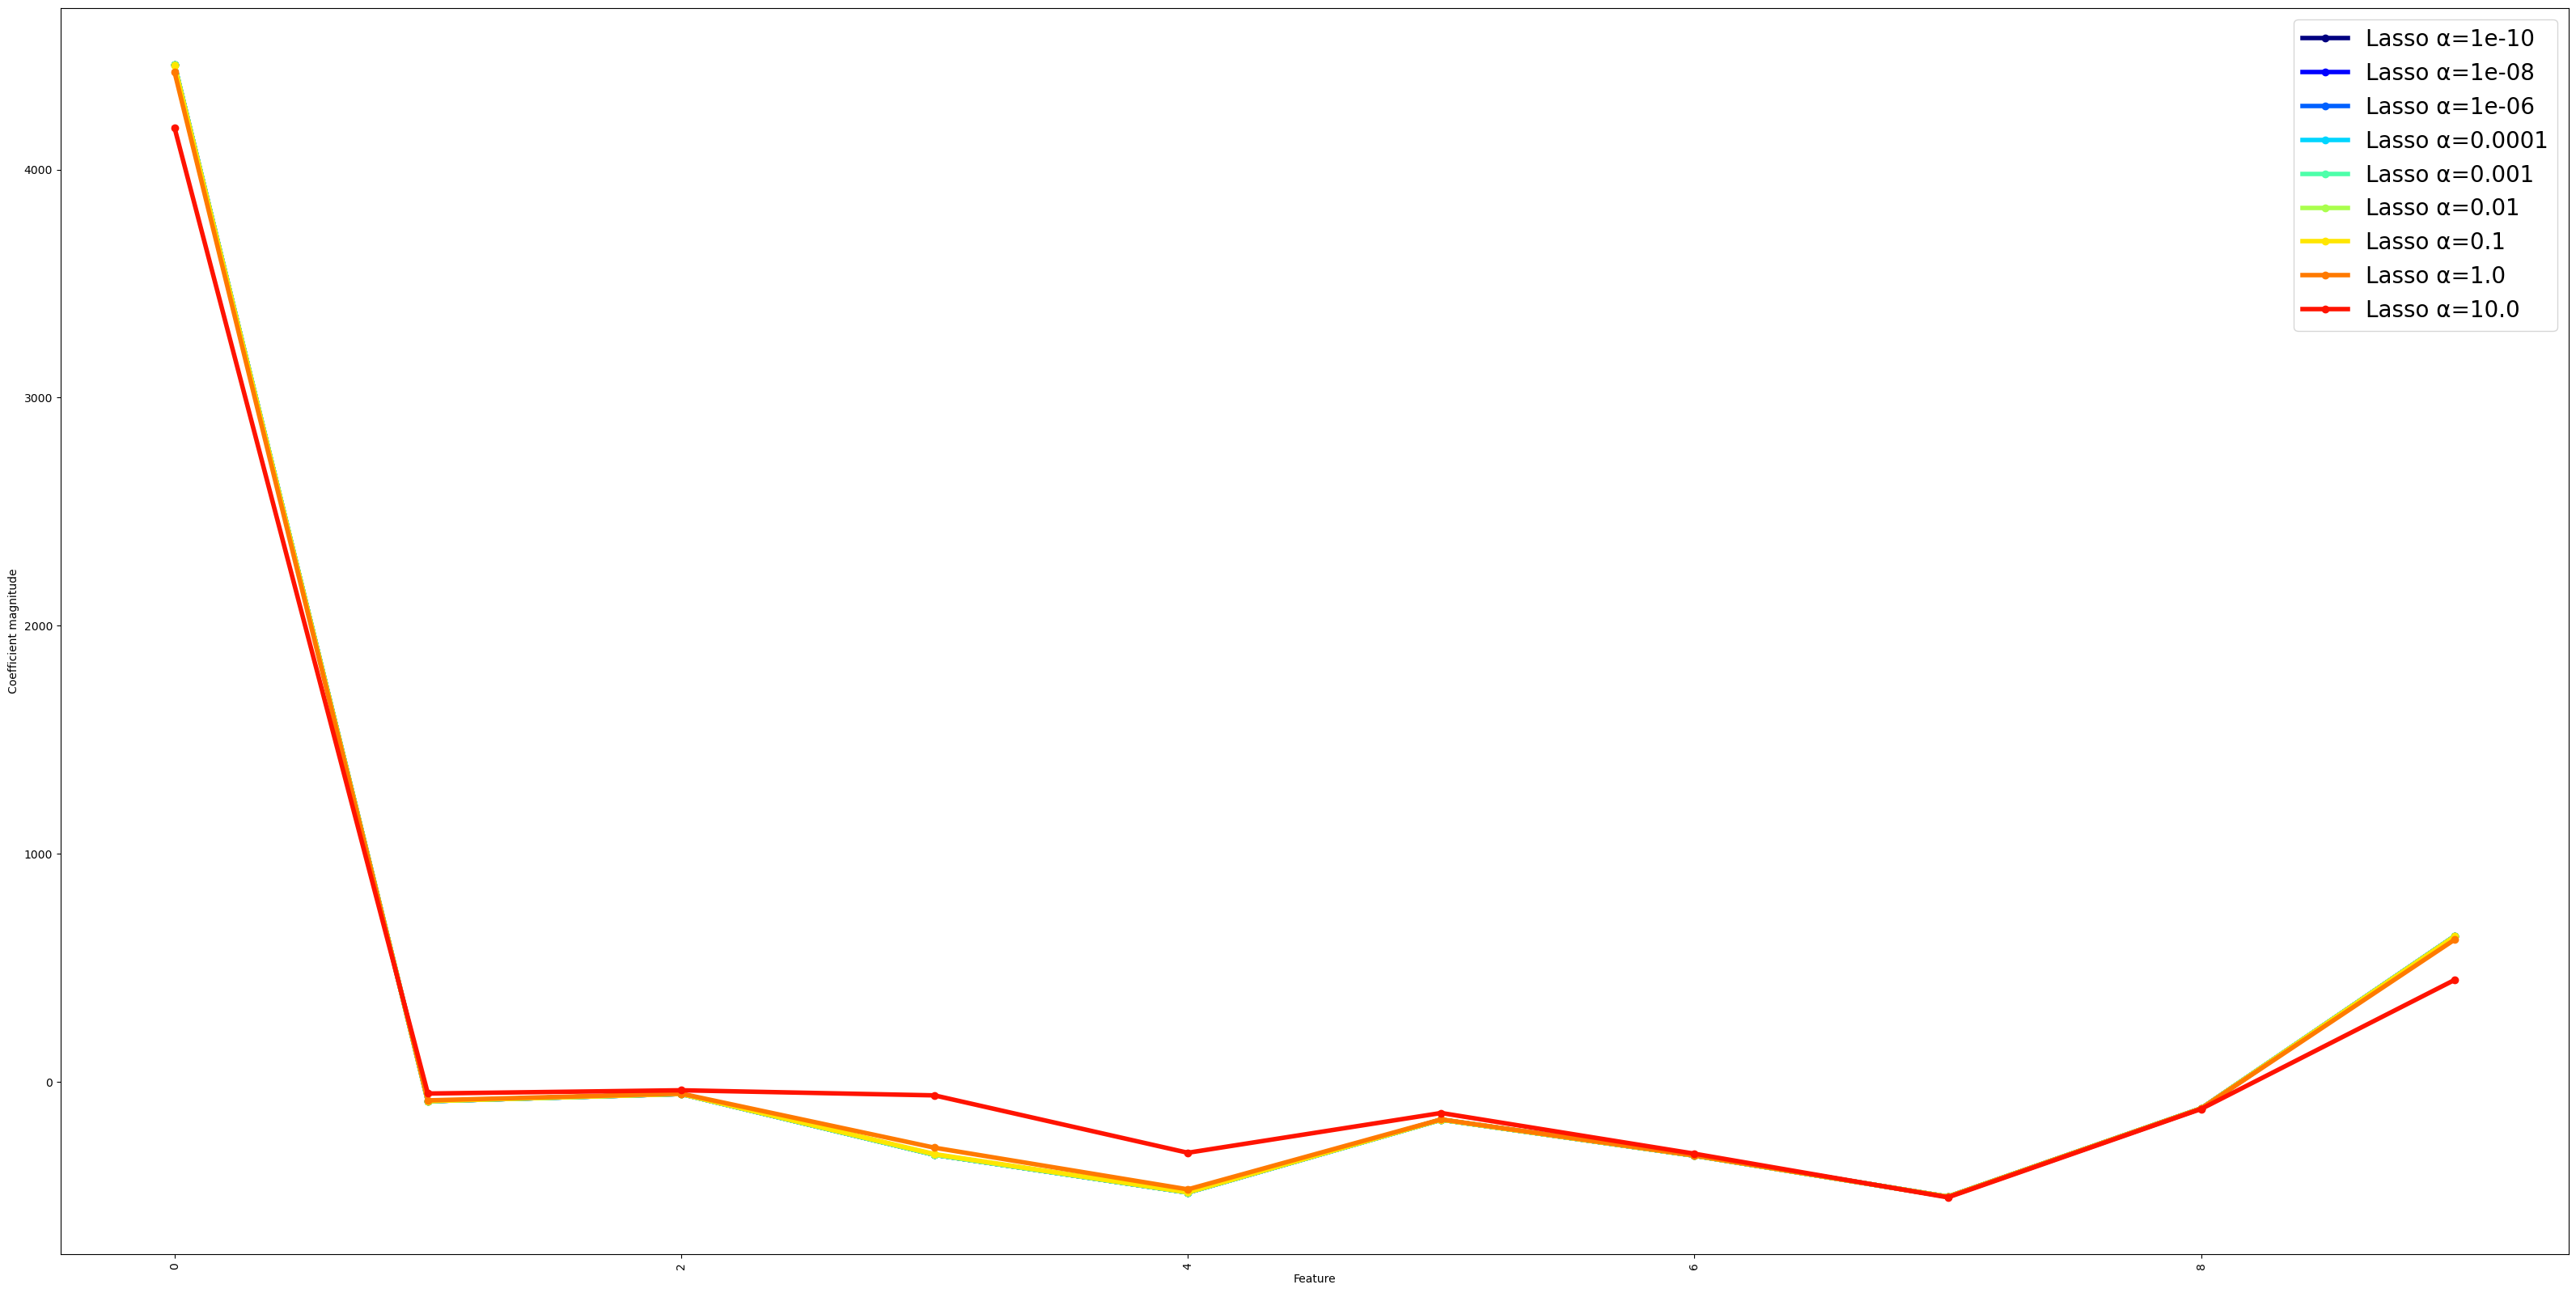

----- Summary of Execution Times -----
KNN Hyperparameter Tuning: 95.41 seconds
Linear Regression: 4.06 seconds
Ridge Regression: 23.13 seconds
Lasso Regression: 1366.50 seconds
-------------------------------------------


In [212]:
stuff = MLmodelsRegressors(features_df, target).auto_test(30, range(5, 9), alphamax=10, num_alphas=10, set_alpha=[1e-10, 1e-8,  1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1], scaler=True)

Note to self: don't trust chatgpt all the time. Also, use a mapping dict. 

In [ ]:
orig = pd.concat([features_df, target], axis=1)
correlation = orig.corr()
correlation

We see that volume, x, y, z are all highly correlated. Let's try dropping them all

In [ ]:
dropped_features = features_df.drop(columns=["volume", "x", "y", "z"])
dropped_features

In [ ]:
stuff = MLmodelsRegressors(dropped_features, target).auto_test(30, range(4, 9), set_alpha=[1e-10, 1e-8, 1e-5, 1e-3, 1e-1, 1, 1e2, 1e4], scaler=True)

This shows only a slight decrease in accuracy. Let's try adding back some features like volume

In [ ]:
dropped_features = features_df.drop(columns=[ "x", "y", "z"])
dropped_features

In [ ]:
stuff = MLmodelsRegressors(dropped_features, target).auto_test(30, range(4, 9), set_alpha=[1e-10, 1e-8, 1e-5, 1e-3, 1e-1, 1, 1e2, 1e4], scaler=True)

In [ ]:
def knn_interpreter_reg(train_df, test_df):
    fig, ax = plt.subplots(figsize=(15, 6))
    params = {'legend.fontsize': 20, 'legend.handlelength': 2}
    plt.rcParams.update(params)
    
    mean_train_accuracy = train_df.mean(axis=1)
    std_train_accuracy = train_df.std(axis=1)
    mean_test_accuracy = test_df.mean(axis=1)
    std_test_accuracy = test_df.std(axis=1)
    
    ax.errorbar(train_df.index, mean_train_accuracy, yerr=std_train_accuracy, label="Mean training accuracy", color='blue', marker='o', linestyle='dashed', markersize=8, capsize=5)
    ax.errorbar(test_df.index, mean_test_accuracy, yerr=std_test_accuracy, label="Mean test accuracy", color='red', marker='^', linestyle='-', markersize=8, capsize=5)
    
    ax.set_ylabel("Accuracy", fontsize=18)
    ax.set_xlabel("Alpha values", fontsize=18)
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.legend()
    plt.show()
    

In [ ]:
laptop_df = pd.read_csv("Regression/laptop_data_cleaned.csv")
features, target = Preprocessor(laptop_df, "Price").hot_encoder(["Company", "TypeName", "Cpu_brand", "Gpu_brand", "Os"]).endpoint()

In [ ]:
features

In [ ]:
MLmodelsRegressors(features, target).auto_test(10, range(1, 40))

MIT License

Copyright (c) [2025] [Jared Villanueva]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.